## Time Series Analysis and Forecasting

### Problem Statement
The objective of this project is to develop a XGBoost-based machine learning model to predict next-hour energy consumption using historical data from the PJME_MW dataset, which includes hourly energy consumption values and a datetime index. The primary challenge is to enhance prediction accuracy during midnight transitions (Hour 0), where the current model exhibits a significant drop in performance due to unique consumption patterns or external factors. The goal is to create a solution that not only maintains high overall accuracy but also effectively captures the specific dynamics of energy consumption at midnight through advanced feature engineering and model optimization techniques.

### About this dataset:
- PJM East Region: 2002-2018 (PJME)
- Estimated energy consumption in Megawatts (MW)

[Dataset Link](https://www.kaggle.com/code/sabarostami/hourly-energy-consumption/input?select=PJME_hourly.csv)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import holidays

# Ensembling XGBoost and lightGBM
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Combine XGBoost with LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
df = pd.read_csv("PJME_hourly.csv.zip")

In [ ]:
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")

In [ ]:
df.isnull().sum()

,0
PJME_MW,0


No missing values wich means there is no need to interpolate (suitable for continuous time series data).
```python
df['PJME_MW'] = df['PJME_MW'].interpolate(method='linear')
```

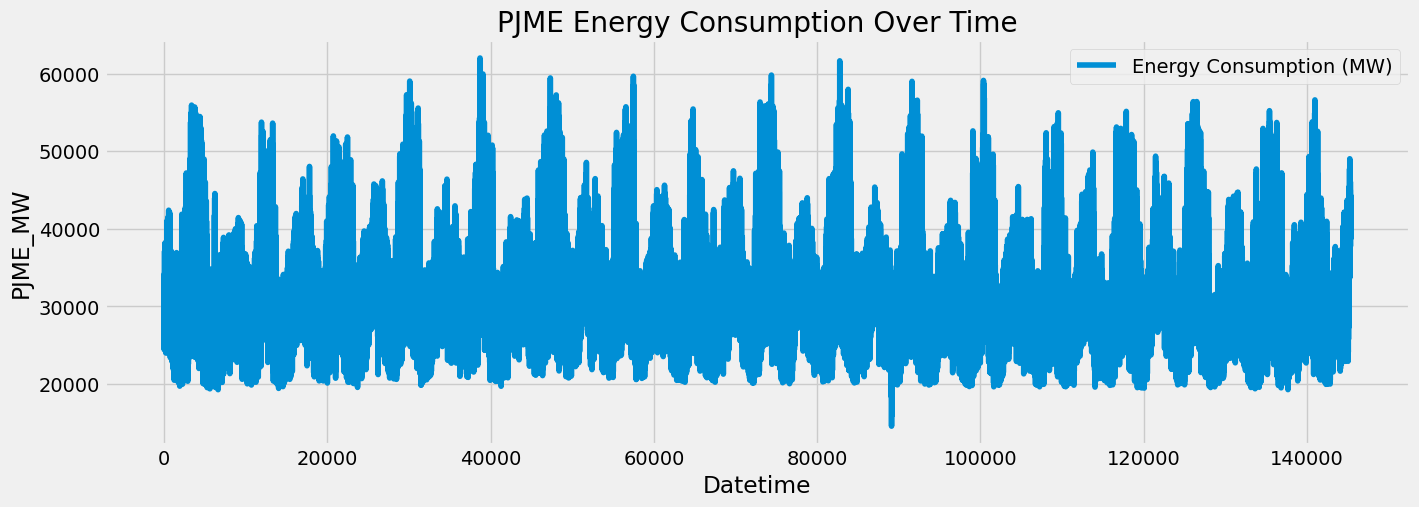

In [ ]:
# Visualize the time series to identify trends, seasonality, or anomalies
plt.figure(figsize=(15, 5))
plt.plot(df['PJME_MW'], label='Energy Consumption (MW)')
plt.title('PJME Energy Consumption Over Time')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

## Outliers

<Axes: ylabel='Frequency'>

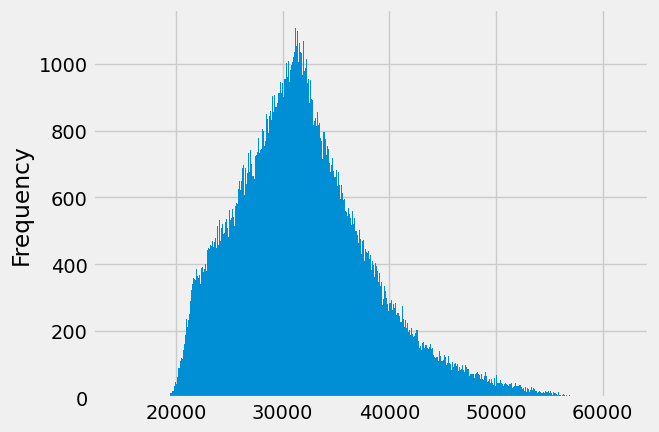

In [ ]:
df["PJME_MW"].plot(kind="hist", bins=500)

<Axes: title={'center': 'Outliers'}>

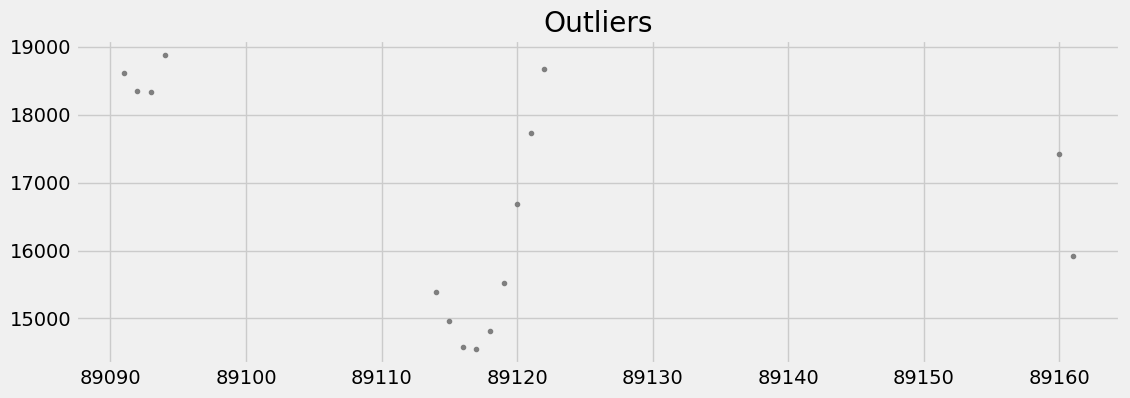

In [ ]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(12, 4),
          color=color_pal[7],
          title='Outliers')

In [ ]:
df = df.query("PJME_MW > 19_000").copy()

## Feature Engineering
XGBoost requires a supervised learning format with features and a target. Since it doesn’t inherently model time series patterns, engineer features to capture trends, seasonality, and autocorrelation.

In [ ]:
# One-step ahead forecasting (predicting the next hour of consumption)
df["target"] = df["PJME_MW"].shift(-1)

By defining the target as df['PJME_MW'].shift(-1), you are explicitly setting up the problem to predict the **next hour's energy consumption** (PJME_MW at time t+1) using the features available at time t.

- Without Shift: If you set the target as PJME_MW directly, you’d be asking XGBoost to predict the current value (PJME_MW at time t) based on features at time t. This isn’t forecasting—it’s more like a regression problem where you’re trying to explain the current value, which isn’t useful for predicting the future.

- With Shift (-1): By shifting PJME_MW by -1, the target becomes the value at the next time step (t+1). This aligns with the forecasting goal: at time t, use features like lagged values (lag_1, lag_2, etc.), hour, day of week, etc., to predict PJME_MW at t+1.



In [ ]:
# Include past values (lags) as predictors (creates columns lag_1 (t-1) to lag_24 (t-24))
for lag in range(1, 25):
  df[f"lag_{lag}"] = df["PJME_MW"].shift(-1)

In [ ]:
def time_based_features_1(df):
  """
  Extract temporal features from the index.
  Since hour, dayofweek, and month are cyclical, we encode them with sine and cosine transformations.
  Add holiday feature.
  Weekly lag_168, (7 days × 24 hours) to capture weekly patterns.
  """
  df = df.copy()
  df["hour"] = df.index.hour
  df["day_of_week"] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
  df["month"] = df.index.month
  df['quarter'] = df.index.quarter
  df["year"] = df.index.year
  df["is_weekend"] = df["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
  df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
  df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
  df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
  df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
  df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
  df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
  us_holidays = holidays.US(years=range(2002, 2019))
  df['is_holiday'] = df.index.isin(us_holidays).astype(int)
  df['lag_168'] = df['PJME_MW'].shift(168)

  return df

**Enhance Feature Engineering**

- **Difference Features:** Add lag_1 - lag_2 or lag_1 - lag_24 to capture short-term trends or daily changes.

- **Seasonal Indicators:** Include binary flags like is_summer (June-August) or is_winter (December-February) to model seasonal shifts, as year has low importance (0.000105).

- **Peak Hour Flags:** Create a feature like is_peak_hour (e.g., 1 for 12 PM-6 PM, 0 otherwise) to highlight high-demand periods.

In [ ]:
df = time_based_features_1(df)

<ipython-input-10-a1eedf8a1123>:22: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.isin(us_holidays).astype(int)


In [ ]:
# Add rolling features to capture local trends, using only past data up to time t for predicting t+1
df["rolling_mean"] = df["PJME_MW"].rolling(window=24).mean()
df["rolling_std"] = df["PJME_MW"].rolling(window=24).std()

Experiment with larger rolling windows (e.g., rolling_mean_48 or rolling_std_48) to detect buildup to peaks or drops to troughs.

In [ ]:
# Drop rows with NaN values (from shifting and rolling)
df.dropna(inplace=True)

In [ ]:
df.head()

,PJME_MW,target,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,is_holiday,lag_168,rolling_mean,rolling_std
Datetime,,,,,,,,,,,,,,,,,,,,,
2002-12-24 01:00:00,27213.0,25643.0,25643.0,25643.0,25643.0,25643.0,25643.0,25643.0,25643.0,25643.0,...,0.258819,0.965926,0.781831,0.62349,-2.449294e-16,1.0,0,26498.0,29475.375,2736.646326
2002-12-24 02:00:00,25643.0,24907.0,24907.0,24907.0,24907.0,24907.0,24907.0,24907.0,24907.0,24907.0,...,0.500000,0.866025,0.781831,0.62349,-2.449294e-16,1.0,0,25147.0,29453.750,2765.861628
2002-12-24 03:00:00,24907.0,24721.0,24721.0,24721.0,24721.0,24721.0,24721.0,24721.0,24721.0,24721.0,...,0.707107,0.707107,0.781831,0.62349,-2.449294e-16,1.0,0,24574.0,29429.750,2804.050165
2002-12-24 04:00:00,24721.0,25144.0,25144.0,25144.0,25144.0,25144.0,25144.0,25144.0,25144.0,25144.0,...,0.866025,0.500000,0.781831,0.62349,-2.449294e-16,1.0,0,24393.0,29416.250,2826.766154
2002-12-24 05:00:00,25144.0,26588.0,26588.0,26588.0,26588.0,26588.0,26588.0,26588.0,26588.0,26588.0,...,0.965926,0.258819,0.781831,0.62349,-2.449294e-16,1.0,0,24860.0,29421.000,2819.160745


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145182 entries, 2002-12-24 01:00:00 to 2018-01-01 23:00:00
Data columns (total 42 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   PJME_MW          145182 non-null  float64
 1   target           145182 non-null  float64
 2   lag_1            145182 non-null  float64
 3   lag_2            145182 non-null  float64
 4   lag_3            145182 non-null  float64
 5   lag_4            145182 non-null  float64
 6   lag_5            145182 non-null  float64
 7   lag_6            145182 non-null  float64
 8   lag_7            145182 non-null  float64
 9   lag_8            145182 non-null  float64
 10  lag_9            145182 non-null  float64
 11  lag_10           145182 non-null  float64
 12  lag_11           145182 non-null  float64
 13  lag_12           145182 non-null  float64
 14  lag_13           145182 non-null  float64
 15  lag_14           145182 non-null  float64
 16  lag_

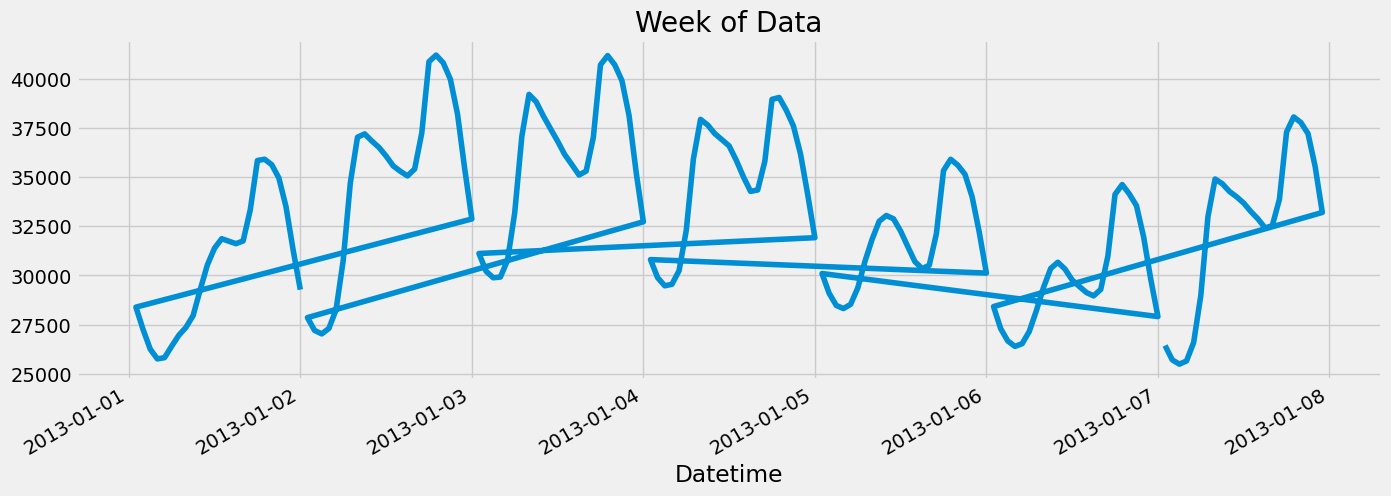

In [ ]:
df['PJME_MW'].loc[(df.index > "01-01-2013") & (df.index < "01-08-2013")] \
        .plot(figsize=(15, 5), title="Week of Data");

The plot reveals strong daily seasonality in energy consumption, with peaks during the day and troughs at night as expected for this kind of data. Our current features (lags, time-based features, rolling statistics, holidays) are well-suited to capture these patterns.

## Data Splitting
Split chronologically to avoid data leakage. We'll use a `fixed data split` that mimics a real-world scenario where you train on historical data (up to 2016) and predict future data (2017 onward). It’s a practical way to evaluate how your model would perform on unseen future data; but for robust evaluation, during model development we'll use `TimeSeriesSplit` to tune hyperparameters and validate model performance across multiple periods, allowing us to assess the model’s performance across multiple time windows, capturing different seasonal patterns (e.g., summer peaks, winter troughs) and potential shifts in behavior (e.g., demand changes over the years).

In [ ]:
train_df = df.loc[df.index < "01-01-2017"]
test_df = df.loc[df.index >= "01-01-2017"]

X_train = train_df.drop('target', axis=1)
y_train = train_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

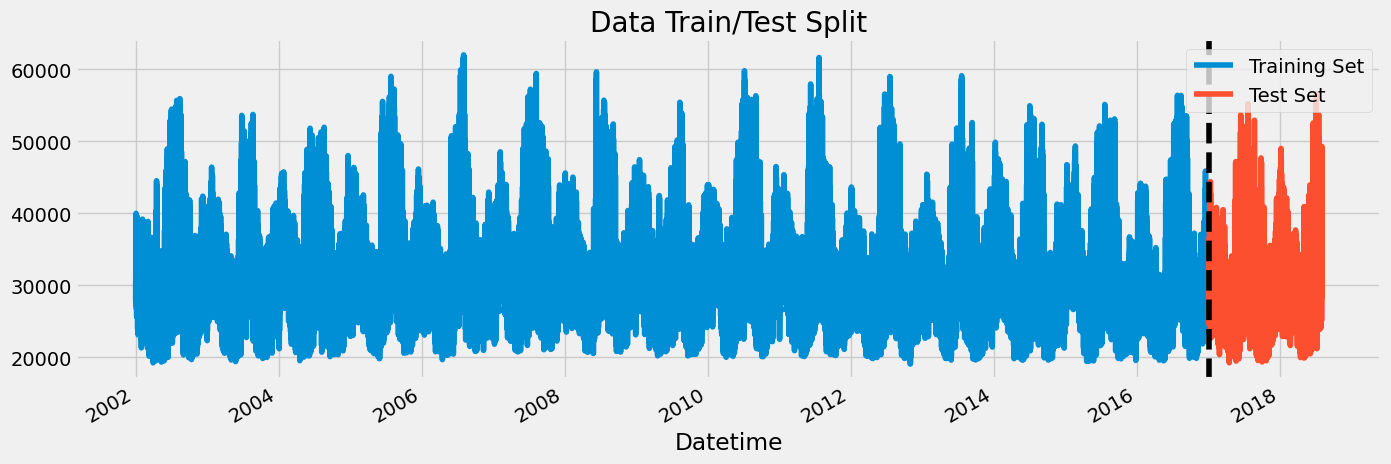

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
train_df['PJME_MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_df['PJME_MW'].plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

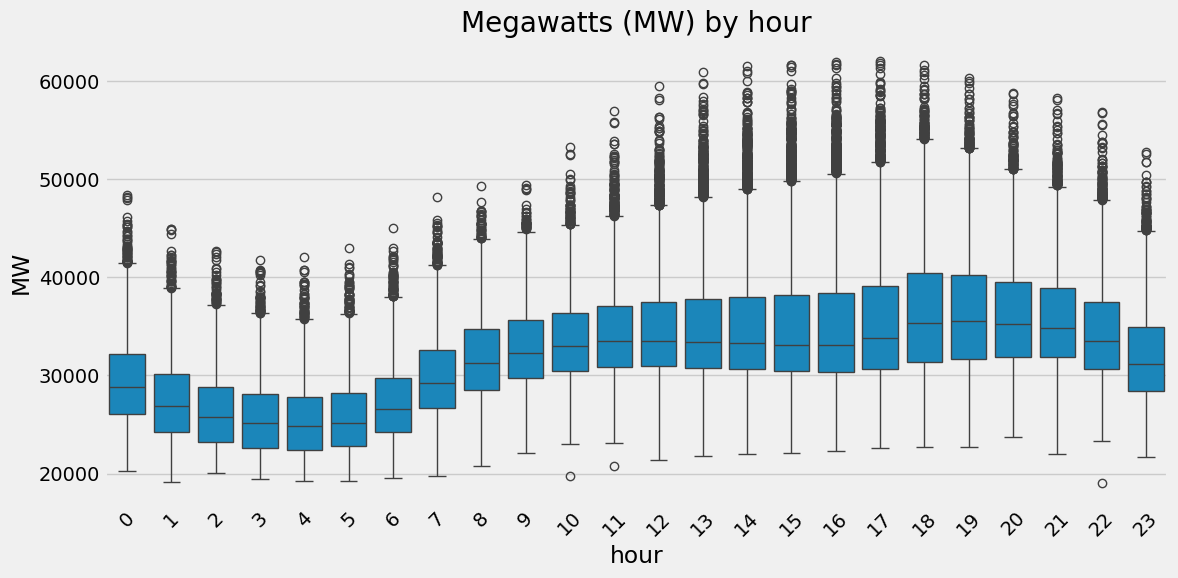

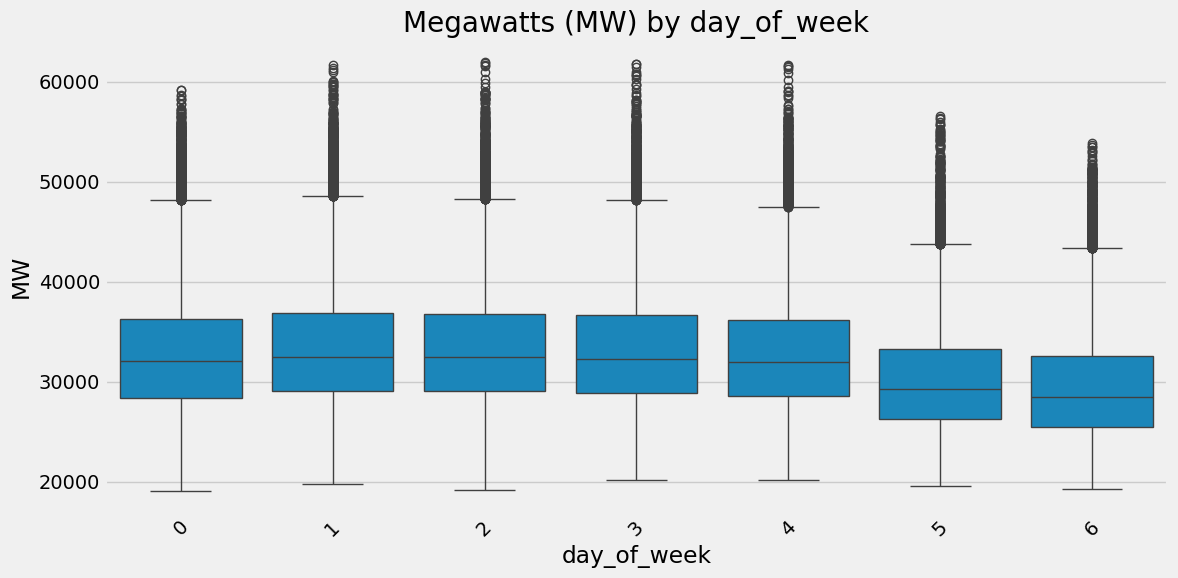

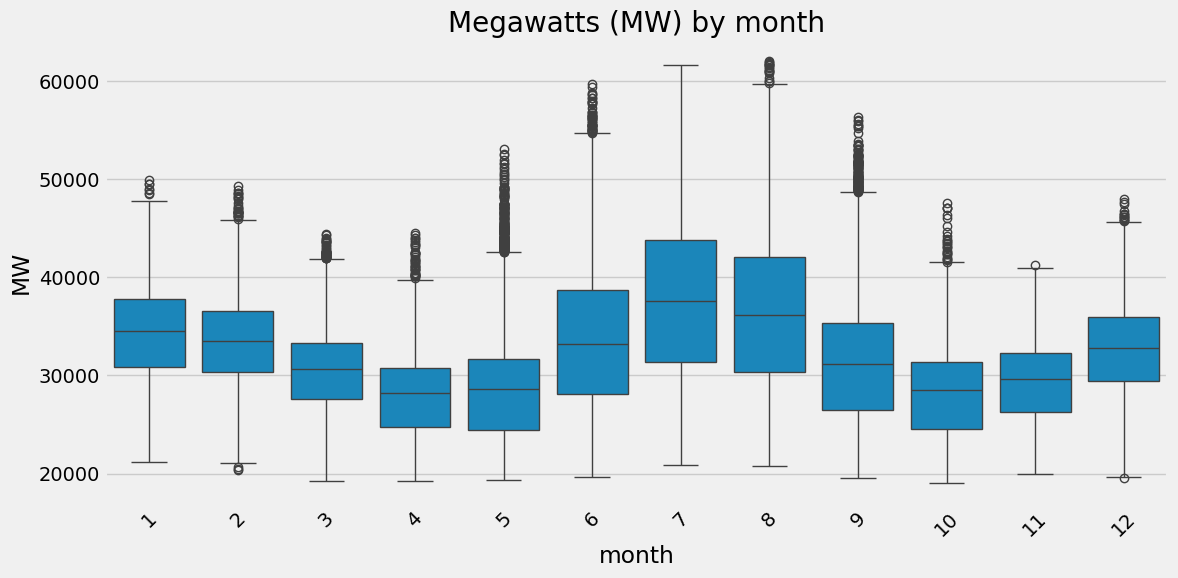

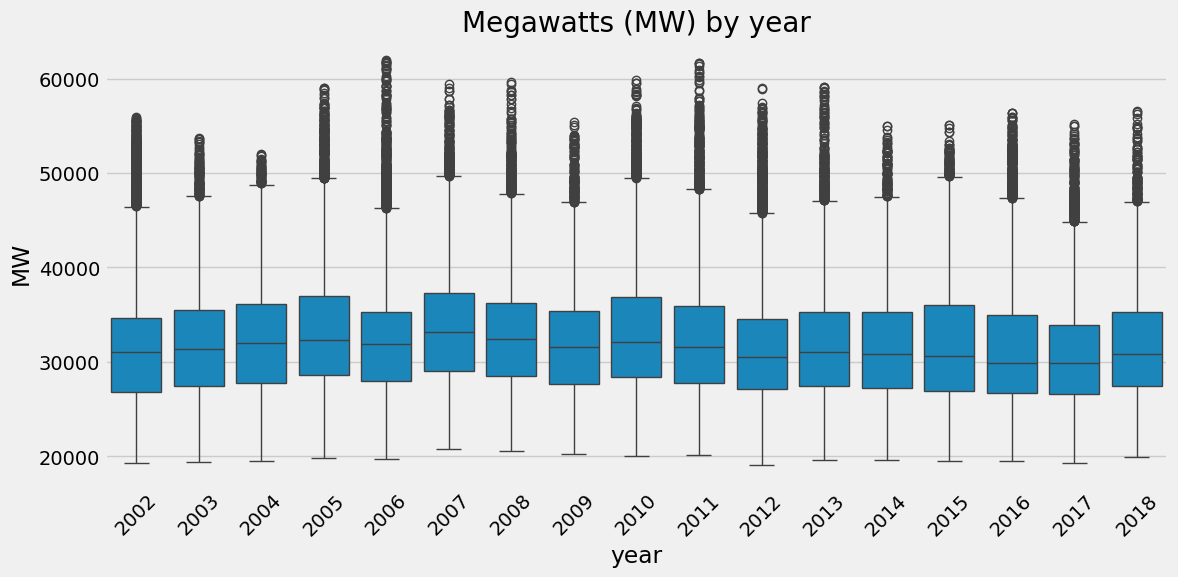

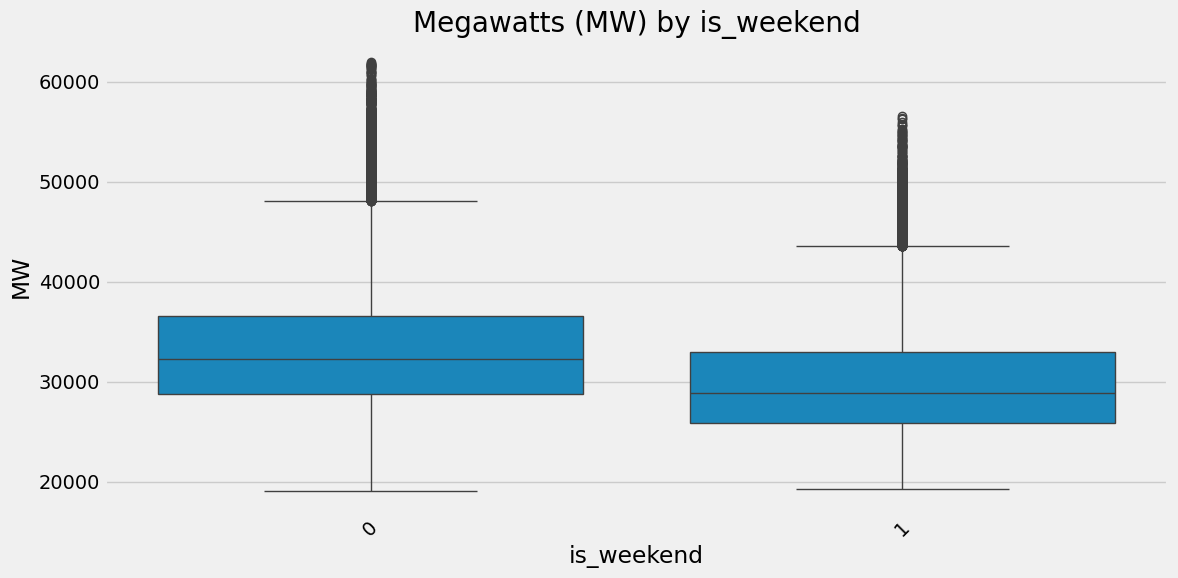

In [ ]:
for col in ['hour', 'day_of_week', 'month', 'year', 'is_weekend']:
  fig, ax = plt.subplots(figsize=(12 , 6))
  sns.boxplot(data=df, x=col, y='PJME_MW')
  ax.set_title(f'Megawatts (MW) by {col}')
  ax.set_xlabel(col)
  ax.set_ylabel('MW')
  ax.tick_params(axis='x', rotation=45)
  plt.tight_layout()
  plt.show()

## Create our Model

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}
model = xgb.XGBRegressor(objective='reg:squarederror')
tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(
    model,
    param_grid,
    cv=tscv,
    scoring='neg_mean_absolute_error'
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, imp...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_absolute_error')

- **Additional Parameters:**
  - subsample: Test values like [0.7, 0.8, 1.0] to introduce randomness and reduce overfitting.

  - colsample_bytree: Try [0.6, 0.8, 1.0] to limit feature sampling per tree.

  - min_child_weight: Experiment with [1, 5, 10] to control tree growth.

- **Optimization Methods:** Switch to random search or Bayesian optimization (e.g., using scikit-optimize or hyperopt) to explore a broader parameter space efficiently.



In [ ]:
for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)
    print(f'Validation MAE: {mean_absolute_error(y_val, y_val_pred):.2f} MW')

Validation MAE: 54.48 MW
Validation MAE: 39.26 MW
Validation MAE: 40.69 MW
Validation MAE: 36.40 MW
Validation MAE: 35.87 MW


Variability in validation MAEs (36.23 MW to 53.59 MW) suggests sensitivity to splits or overfitting.

## Make Predictions and Evaluate

In [ ]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f'MAE: {mae:.2f} MW')
print(f'RMSE: {rmse:.2f} MW')
print(f'MAPE: {mape:.2f} %')

MAE: 31.35 MW
RMSE: 61.68 MW
MAPE: 0.10 %


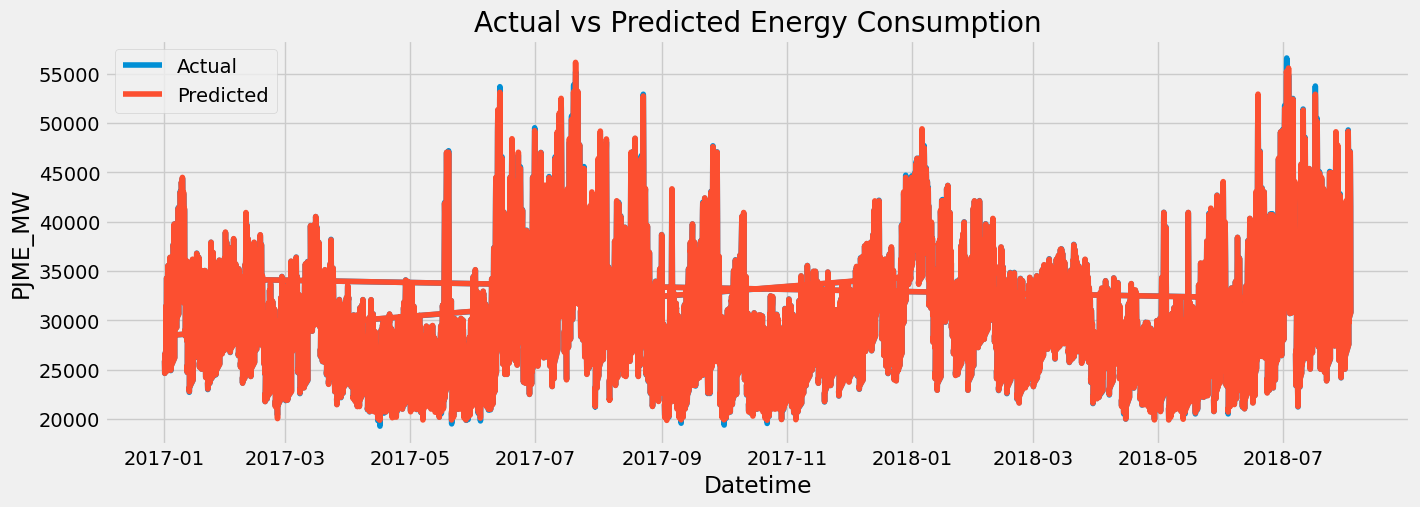

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test_df.index, y_test, label='Actual')
plt.plot(test_df.index, y_pred, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

In [ ]:
# Feature Importance
pd.DataFrame(
    model.feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance', ascending=False).head(10)

,Importance
lag_1,0.998207
PJME_MW,0.000522
day_of_week_cos,0.000332
rolling_mean,0.000247
hour,0.000119
year,0.000117
day_of_week_sin,0.000108
rolling_std,0.000076
month,0.000073
lag_168,0.000054


lag_1 (previous hour’s consumption) dominates with a score of 0.997919, while other features contribute minimally. This suggests the model might be overfitting to the most recent value and not fully leveraging the rich feature set we’ve created.

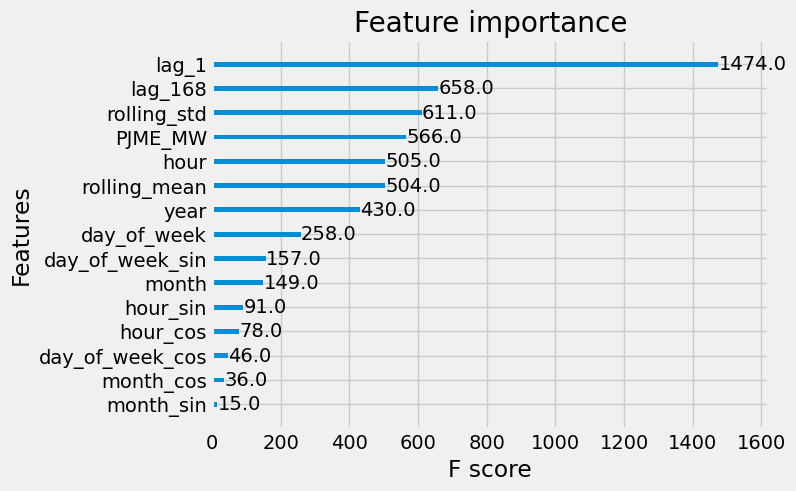

In [ ]:
xgb.plot_importance(model)
plt.show()

## Worst and Best Predicted Days

In [ ]:
test_df['error'] = np.abs(test_df["target"] - y_pred)
test_df['date'] = test_df.index.date
test_df.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

<ipython-input-29-655b022e259c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['error'] = np.abs(test_df["target"] - y_pred)
<ipython-input-29-655b022e259c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index.date


,error
date,
2018-07-02,296.859375
2017-07-20,247.404460
2018-07-03,175.420410
2017-07-19,174.689779
2018-07-16,169.682861
2017-06-13,141.311930
2018-01-05,130.784831
2018-07-10,129.433512
2018-06-18,126.778646


In [ ]:
test_df['error'] = np.abs(test_df["target"] - y_pred)
test_df['date'] = test_df.index.date
test_df.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

<ipython-input-30-9ed4f42fb33c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['error'] = np.abs(test_df["target"] - y_pred)
<ipython-input-30-9ed4f42fb33c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date'] = test_df.index.date


,error
date,
2018-08-03,8.484375
2017-02-21,11.431234
2018-04-17,12.338542
2018-03-27,12.705729
2018-01-23,12.873372
2017-01-18,13.119141
2018-04-11,13.358154
2018-04-05,13.464111
2018-02-18,13.507650


## Addressing Some Improvements that Might Help our Model

**Key Improvements:**
1. Regularization: Added L1 (alpha) and L2 (lambda) regularization to balance feature contributions and prevent overreliance on lag_1.

2. Enhanced Feature Engineering:
  - Added more lag features (e.g., lag_48, lag_336) for deeper temporal patterns.

  - Included rolling window features (e.g., rolling_mean_48) to capture trends.

  - Created difference features, seasonal indicators, peak hour flags, and interaction terms to improve peak/trough predictions.

3. Cyclical Encoding: Used sine/cosine transformations for hour, day_of_week, and month to model seasonality.

4. Hyperparameter Tuning: Expanded the grid search to include subsample, colsample_bytree, and min_child_weight.

4. Residual Analysis: Added residual plots to identify model weaknesses.


In [ ]:
# Define the target as the next hour's consumption (one-step-ahead forecasting)
df['target'] = df['PJME_MW'].shift(-1)

# Add lag features (past values as predictors)
for lag in range(1, 25):  # Hourly lags up to 24 hours
    df[f'lag_{lag}'] = df['PJME_MW'].shift(lag)
df['lag_48'] = df['PJME_MW'].shift(48)    # Same hour, two days ago
df['lag_336'] = df['PJME_MW'].shift(336)  # Same hour, two weeks ago

# Function to create time-based features
def time_based_features_2(df):
    """Extract temporal features with cyclical encoding and holidays."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Cyclical encoding for hour, day_of_week, and month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Add US holidays
    us_holidays = holidays.US(years=range(df.index.year.min(), df.index.year.max() + 1))
    df['is_holiday'] = df.index.isin(us_holidays).astype(int)

    # Weekly lag for seasonal patterns
    df['lag_168'] = df['PJME_MW'].shift(168)  # Same hour, one week ago

    return df

df = time_based_features_2(df)

# Add rolling window features
df['rolling_mean_24'] = df['PJME_MW'].rolling(window=24).mean()
df['rolling_std_24'] = df['PJME_MW'].rolling(window=24).std()
df['rolling_mean_48'] = df['PJME_MW'].rolling(window=48).mean()
df['rolling_std_48'] = df['PJME_MW'].rolling(window=48).std()

# Add difference features to capture short-term changes
df['diff_lag1_lag2'] = df['lag_1'] - df['lag_2']
df['diff_lag1_lag24'] = df['lag_1'] - df['lag_24']

# Add seasonal indicators
df['is_summer'] = df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
df['is_winter'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)

# Add peak hour flag (12 PM - 6 PM)
df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if 12 <= x <= 18 else 0)

# Add interaction terms for peak/trough modeling
df['hour_is_holiday'] = df['hour'] * df['is_holiday']
df['hour_is_weekend'] = df['hour'] * df['is_weekend']

# Drop rows with NaN values from shifts and rolling calculations
df.dropna(inplace=True)

<ipython-input-31-e7f3fd8b1f9c>:30: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.isin(us_holidays).astype(int)


In [ ]:
# Split into train (before 2017) and test (2017 and later) sets
train_df = df.loc[df.index < '2017-01-01']
test_df = df.loc[df.index >= '2017-01-01']

X_train = train_df.drop('target', axis=1)
y_train = train_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

# Define XGBoost model and hyperparameter grid
model = xgb.XGBRegressor(objective='reg:squarederror')
param_dist  = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],         # Fraction of samples used per tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Fraction of features used per tree
    'min_child_weight': [1, 5, 10],       # Minimum sum of instance weight in a child
    'lambda': [0.1, 1, 10],               # L2 regularization
    'alpha': [0.1, 1, 10]                 # L1 regularization
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform randomized search
random_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=20,  # Number of parameter settings to sample
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42  # For reproducibility
)
random_search.fit(X_train, y_train)

# Get the best model
best_model = random_search.best_estimator_
print('Best Parameters:', random_search.best_params_)
print('Best CV MAE:', -random_search.best_score_)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.1, 'lambda': 1, 'colsample_bytree': 1.0, 'alpha': 10}
Best CV MAE: 314.7437997744845


- These settings reflect a balanced approach: moderate regularization (lambda: 1, alpha: 10) prevents overfitting, while subsample (0.7) and colsample_bytree (1.0) ensure the model uses a subset of data and all features per tree, reducing variance.

- However, we could increase regularization values (e.g., alpha: [20, 50], lambda: [5, 10]) to further penalize the model’s reliance on any single feature like PJME_MW and make the model more robust. Alternatively, reduce colsample_bytree (e.g., to 0.6 or 0.8) to randomly sample features per tree, encouraging the model to use a more diverse set of features.

```python
# Define XGBoost model with regularization
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8],            # Fraction of samples used per tree
    'colsample_bytree': [0.6, 0.8],     # Fraction of features used per tree
    'min_child_weight': [5, 10],        # Minimum sum of instance weight in a child
    'lambda': [5, 10],                  # L2 regularization
    'alpha': [20, 50]                   # L1 regularization
}
```

In [ ]:
# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f'Test MAE: {mae:.2f} MW')
print(f'Test RMSE: {rmse:.2f} MW')
print(f'Test MAPE: {mape:.2f} %')

Test MAE: 320.46 MW
Test RMSE: 569.03 MW
Test MAPE: 1.05 %


The close alignment between the cross-validation MAE (315.53 MW) and test MAE (320.46 MW) indicates that the model generalizes well to unseen data, with minimal overfitting. The Test MAPE of 1.05% is particularly impressive, showing that, on average, predictions deviate by only 1.05% from actual values—a strong result for energy forecasting. However, the Test RMSE (569.03 MW) is higher than the MAE, suggesting that while most errors are small, there are some larger errors (likely during peaks or troughs), as RMSE is more sensitive to outliers.

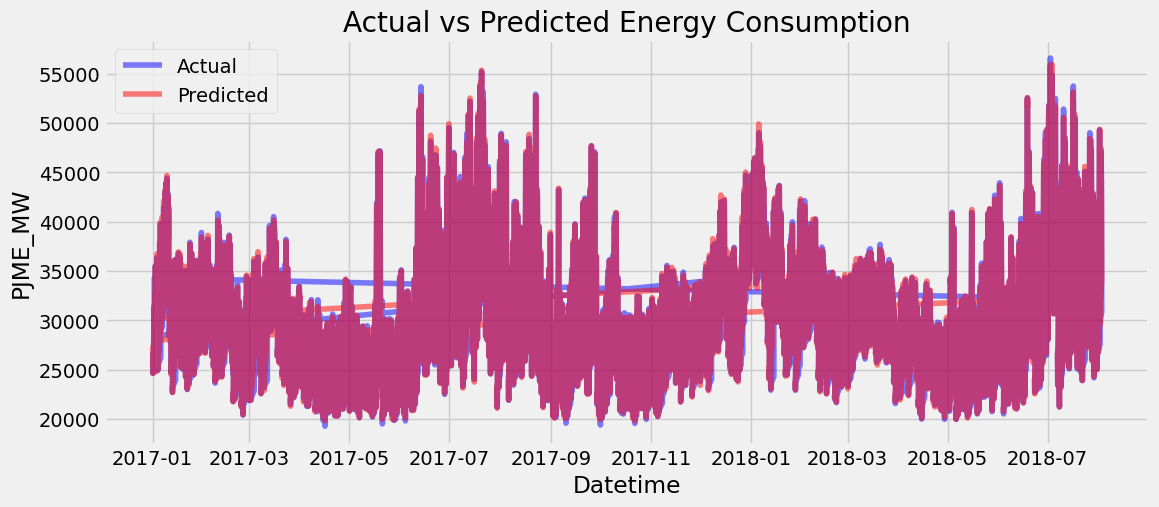

In [ ]:
# Plot actual vs predicted (similar to your graph)
plt.figure(figsize=(12, 5))
plt.plot(test_df.index, y_test, label='Actual', color='blue', alpha=0.5)
plt.plot(test_df.index, y_pred, label='Predicted', color='red', alpha=0.5)
plt.title('Actual vs Predicted Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

- **Time Span:** January 2017 to July/August 2018 (18 months).

- **Range:** Energy consumption fluctuates between 20,000 MW and 55,000 MW, with peaks in summer (e.g., July 2017, July 2018) and winter (e.g., January 2018), and troughs in spring/fall (e.g., April 2017, October 2017).

- **Observations:**
  - The predicted (red) line closely tracks the actual (blue) line, capturing seasonal cycles and daily fluctuations effectively.

  - At peaks (e.g., July 2017, 50,000 MW), predictions sometimes underestimate (47,000–48,000 MW), and at troughs (e.g., April 2017, 25,000 MW), they occasionally overestimate (27,000 MW). This smoothing effect explains the higher RMSE (569.03 MW) compared to MAE (320.46 MW).

  - The low MAPE (1.05%) aligns with the tight overall fit, despite minor deviations at extremes.

In [ ]:
# Display top 10 feature importances
feature_importance = pd.DataFrame(
    best_model.feature_importances_,
    index=X_train.columns,
    columns=['Importance']
).sort_values(by='Importance', ascending=False)
print('Top 10 Feature Importances:')
print(feature_importance.head(10))

Top 10 Feature Importances:
          Importance
PJME_MW     0.773443
hour_cos    0.073002
lag_21      0.023012
lag_22      0.015477
lag_10      0.014856
lag_1       0.008330
lag_20      0.007798
hour_sin    0.006656
lag_9       0.006608
lag_19      0.005315


- PJME_MW (0.773443): This feature dominates, since PJME_MW at time t is the most recent observation of energy consumption before the target (t+1), it’s intuitive that it would be a highly predictive feature. Energy consumption tends to be highly autocorrelated—meaning the value at t is strongly correlated with the value at t+1 due to the continuity of demand patterns (e.g., daily cycles, seasonal trends).


- hour_cos (0.073002) and hour_sin (0.006656): These cyclical encodings capture daily patterns, such as higher demand during daytime hours, and their presence in the top 10 confirms the model accounts for hourly fluctuations.

- Lag Features (lag_21, lag_22, etc.): Multiple lagged values (e.g., 21, 22, 10 days ago) suggest the model uses past data to detect short- and medium-term trends, critical for predicting energy usage.
---

- **Feature Redundancy:**
  - While it’s logical for PJME_MW to be important, its dominance (0.773443) compared to other features (e.g., hour_cos at 0.073002, lag_21 at 0.023012) suggests the model might be underutilizing other features that could improve predictions, especially for capturing longer-term patterns or external factors.

  - PJME_MW and the lag features (lag_1, lag_2, etc.) are all derived from the same underlying data (PJME_MW at different time steps). This redundancy could lead the model to overfit to the lagged structure of the data rather than learning from other features like hour_cos, is_holiday, or rolling_mean.

  - **Reduce Redundancy with Lags:**
    - Since PJME_MW is already capturing the most recent value (t), we might experiment with removing or reducing the number of short-term lag features (lag_1, lag_2, etc.) to force the model to rely more on other features. For example, keep only longer lags like lag_24, lag_48, or lag_168 to capture daily or weekly patterns.

    - Alternatively, we can scale down PJME_MW (e.g., divide by a constant like 10,000) to reduce its dominance in splits while retaining its information.

```python
# Add lag features (reduced short-term lags, focus on longer-term patterns)
for lag in [24, 48, 168, 336]:  # Daily, 2-day, weekly, and 2-week lags
    df[f'lag_{lag}'] = df['PJME_MW'].shift(lag)

# Function to create time-based features
def time_based_features(df):
    """Extract temporal features with cyclical encoding and holidays."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Cyclical encoding for hour, day_of_week, and month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Add US holidays
    us_holidays = holidays.US(years=range(df.index.year.min(), df.index.year.max() + 1))
    df['is_holiday'] = df.index.isin(us_holidays).astype(int)
    
    return df

# Add interaction term
df['PJME_hour_cos'] = df['PJME_MW'] * df['hour_cos']

# Check correlations between PJME_MW and lags
corr_matrix = df[['PJME_MW', 'lag_24', 'lag_48', 'lag_168', 'lag_336']].corr()
print("Correlation Matrix:")
print(corr_matrix)
```
---



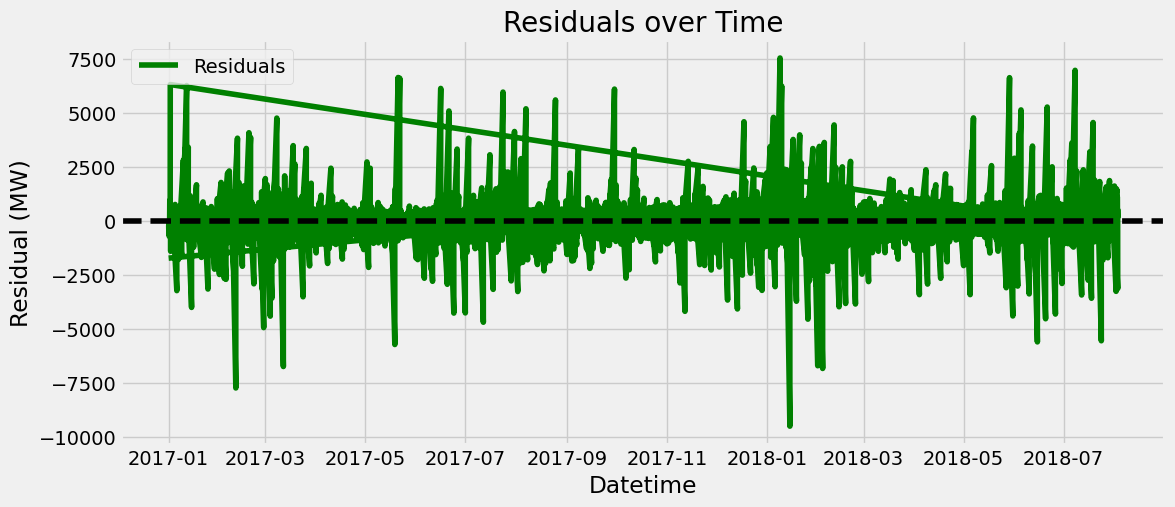

In [ ]:
# Residual analysis: Plot residuals over time
residuals = y_test - y_pred
plt.figure(figsize=(12, 5))
plt.plot(test_df.index, residuals, label='Residuals', color='green')
plt.title('Residuals over Time')
plt.xlabel('Datetime')
plt.ylabel('Residual (MW)')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()

- **Range:** Residuals span -10,000 MW to +7,500 MW, with most within -5,000 MW to +5,000 MW.

- **Patterns:**
  - Periodic spikes occur around peak seasons (e.g., July 2017, January 2018), with large positive residuals (underpredictions) during high demand and negative residuals (overpredictions) during low demand.

  - A slight downward trend in residuals suggests increasing overprediction toward July 2018, though this could be dataset-specific.

- **Implication:** The model struggles with extreme values, contributing to the RMSE, but the MAE and MAPE remain low due to smaller errors elsewhere.

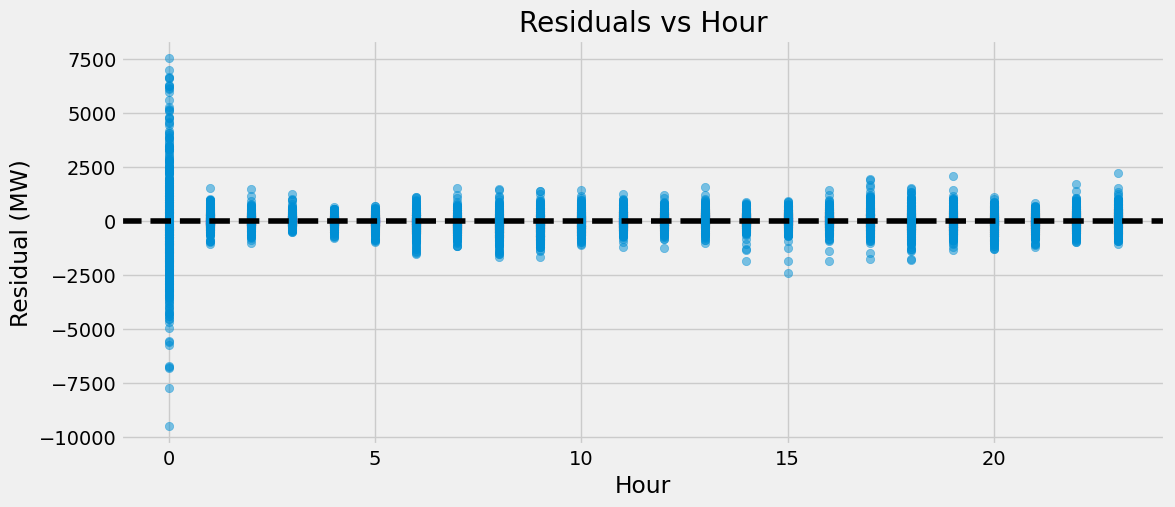

In [ ]:
# Residuals vs Hour to check for patterns
plt.figure(figsize=(12, 5))
plt.scatter(test_df['hour'], residuals, alpha=0.5)
plt.title('Residuals vs Hour')
plt.xlabel('Hour')
plt.ylabel('Residual (MW)')
plt.axhline(0, color='black', linestyle='--')
plt.show()

- **Hourly Variation:**
  - **Hour 0:** Largest residual spread (-10,000 MW to +7,500 MW), with extreme outliers and a median slightly below 0 MW, indicating significant prediction challenges at midnight.

  - **Hours 1–23:** Tighter spreads (~-2,000 MW to +2,000 MW), medians near 0 MW, and fewer outliers, showing stable performance throughout the day.

- **Implication:** The model excels during most hours, leveraging hour_cos and hour_sin, but Hour 0’s errors suggest that predictions at midnight are highly variable and prone to error compared to other hours due missing factors (e.g., overnight demand shifts) not fully captured.
---

**Updated the Code to Implement Residual-Driven Adjustments**
```python
# Add overnight load indicators
df['is_hour_0'] = (df['hour'] == 0).astype(int)  # Binary flag for Hour 0
df['is_hour_0_weekend'] = df['is_hour_0'] * df['is_weekend']  # Interaction with weekend
df['is_hour_0_holiday'] = df['is_hour_0'] * df['is_holiday']  # Interaction with holiday
df['is_hour_0_winter'] = df['is_hour_0'] * df['is_winter']    # Interaction with winter season
df['rolling_mean_6'] = df['PJME_MW'].rolling(window=6).mean()  # Rolling mean of past 6 hours as a proxy for overnight load

# Interaction term with PJME_MW
df['PJME_hour_cos'] = df['PJME_MW'] * df['hour_cos']

# Residual analysis: Focus on Hour 0
residuals = y_test - y_pred
test_df['residuals'] = residuals
hour_0_residuals = test_df[test_df['hour'] == 0]['residuals']

# Plot Hour 0 residuals over time
plt.figure(figsize=(14, 7))
plt.plot(test_df[test_df['hour'] == 0].index, hour_0_residuals, label='Hour 0 Residuals', color='purple')
plt.title('Hour 0 Residuals Over Time')
plt.xlabel('Datetime')
plt.ylabel('Residual (MW)')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()

# Analyze Hour 0 residuals by weekend/holiday/winter
print("Hour 0 Residuals Statistics:")
print(hour_0_residuals.describe())
print("\nHour 0 Residuals by Weekend:")
print(test_df[test_df['hour'] == 0].groupby('is_weekend')['residuals'].mean())
print("\nHour 0 Residuals by Holiday:")
print(test_df[test_df['hour'] == 0].groupby('is_holiday')['residuals'].mean())
print("\nHour 0 Residuals by Winter Season:")
print(test_df[test_df['hour'] == 0].groupby('is_winter')['residuals'].mean())

# Updated Residuals vs Hour plot to check improvement
plt.figure(figsize=(14, 7))
plt.scatter(test_df['hour'], test_df['residuals'], alpha=0.5)
plt.title('Updated Residuals vs Hour')
plt.xlabel('Hour')
plt.ylabel('Residual (MW)')
plt.axhline(0, color='black', linestyle='--')
plt.show()
```
  ---

## How the Model Performs Now
- **Strengths:**
  - Excellent overall accuracy (MAPE: 1.05%), competitive with industry standards for energy forecasting.

  - Strong generalization (CV MAE ≈ Test MAE), supported by regularization and balanced hyperparameters.

  - Effective capture of seasonal and hourly patterns, as seen in the Actual vs Predicted plots and feature importances (PJME_MW, hour_cos, lags).

- **Weaknesses:**
  - Slight underestimation of peaks and overestimation of troughs, visible in the plots and reflected in the RMSE (569.03 MW).

  - Significant errors at Hour 0 and during extreme periods, indicating limitations in handling outliers or unique conditions.
---

## Leveraging Ensembling Models by Combining XGBoost with LightGBM Via Weighted Averaging and Stacking

**Why Combine XGBoost and LightGBM?**

Combining XGBoost and LightGBM through ensembling is a powerful strategy because these models have complementary strengths:

- **XGBoost:** Known for its robustness, XGBoost excels at handling structured data with complex interactions. It’s particularly effective at capturing overall trends and patterns in energy consumption, such as seasonal fluctuations seen in your "Actual vs Predicted Energy Consumption" plots.

- **LightGBM:** Optimized for speed and scalability, LightGBM uses a leaf-wise tree growth approach, making it adept at capturing fine-grained patterns in large datasets. This can be especially useful for nuanced behaviors, like the large residual spread at Hour 0 in our "Residuals vs Hour" plot.

- **Complementary Error Patterns:** As seen in your residual plots, prediction errors vary across time and hours. If XGBoost and LightGBM make different types of errors (e.g., one underpredicts peaks while the other overpredicts troughs), combining them can balance these discrepancies, leading to more accurate forecasts.

- **Improved Generalization:** Ensembling diverse models reduces overfitting by averaging out biases and variances, enhancing performance on unseen data.

Our "Actual vs Predicted Energy Consumption" plots show that the current model captures trends but struggles with extreme peaks (e.g., July 2017, July 2018) and troughs, while the "Residuals vs Hour" plot highlights significant errors at Hour 0. Ensembling can address these issues by leveraging the strengths of both models.


### Step 1: Train Individual Models (XGBoost and LightGBM)

In [ ]:
# Define the target (next hour's consumption)
df['target'] = df['PJME_MW'].shift(-1)

# Split into train (before 2017) and test (2017 and later) sets
train_df = df.loc[df.index < '2017-01-01']
test_df = df.loc[df.index >= '2017-01-01']

X_train = train_df.drop('target', axis=1)
y_train = train_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

# Add lag features (reduced short-term lags, focus on longer-term patterns)
for lag in [24, 48, 168, 336]:  # Daily, 2-day, weekly, and 2-week lags
    df[f'lag_{lag}'] = df['PJME_MW'].shift(lag)

# Function to create time-based features
def time_based_features_3(df):
    """Extract temporal features with cyclical encoding and holidays."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek  # 0 = Monday, 6 = Sunday
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Cyclical encoding for hour, day_of_week, and month
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    # Add US holidays
    us_holidays = holidays.US(years=range(df.index.year.min(), df.index.year.max() + 1))
    df['is_holiday'] = df.index.isin(us_holidays).astype(int)

    # Add seasonal indicators
    df['is_summer'] = df['month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
    df['is_winter'] = df['month'].apply(lambda x: 1 if x in [12, 1, 2] else 0)

    return df

df = time_based_features_3(df)

# Add interaction term
df['PJME_hour_cos'] = df['PJME_MW'] * df['hour_cos']

# Add rolling window features
df['rolling_mean_24'] = df['PJME_MW'].rolling(window=24).mean()
df['rolling_std_24'] = df['PJME_MW'].rolling(window=24).std()
df['rolling_mean_48'] = df['PJME_MW'].rolling(window=48).mean()
df['rolling_std_48'] = df['PJME_MW'].rolling(window=48).std()

# Add peak hour flag (12 PM - 6 PM)
df['is_peak_hour'] = df['hour'].apply(lambda x: 1 if 12 <= x <= 18 else 0)

# Add interaction terms for peak/trough modeling
df['hour_is_holiday'] = df['hour'] * df['is_holiday']
df['hour_is_weekend'] = df['hour'] * df['is_weekend']

# Add interaction term
df['PJME_hour_cos'] = df['PJME_MW'] * df['hour_cos']

# Add overnight load indicators
df['is_hour_0'] = (df['hour'] == 0).astype(int)                # Binary flag for Hour 0
df['is_hour_0_weekend'] = df['is_hour_0'] * df['is_weekend']   # Interaction with weekend
df['is_hour_0_holiday'] = df['is_hour_0'] * df['is_holiday']   # Interaction with holiday
df['is_hour_0_winter'] = df['is_hour_0'] * df['is_winter']     # Interaction with winter season
df['rolling_mean_6'] = df['PJME_MW'].rolling(window=6).mean()  # Rolling mean of past 6 hours as a proxy for overnight load

# Drop rows with NaN values from shifts and rolling calculations
df.dropna(inplace=True)

<ipython-input-7-099817488de8>:38: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df.index.isin(us_holidays).astype(int)


In [ ]:
# --- XGBoost RandomizedSearchCV ---
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')
xgb_param_grid= {
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8],            # Fraction of samples used per tree
    'colsample_bytree': [0.6, 0.8],     # Fraction of features used per tree
    'min_child_weight': [5, 10],        # Minimum sum of instance weight in a child
    'lambda': [5, 10],                  # L2 regularization
    'alpha': [20, 50]                   # L1 regularization
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform randomized search
xgb_random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=50,  # Number of parameter settings to sample
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42  # For reproducibility
)
xgb_random_search.fit(X_train, y_train)

# Best XGBoost model
best_xgb_model = xgb_random_search.best_estimator_
print('XGBoost Best Parameters:', xgb_random_search.best_params_)
print('XGBoost Best CV MAE:', -xgb_random_search.best_score_)

XGBoost Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'lambda': 10, 'colsample_bytree': 0.8, 'alpha': 20}
XGBoost Best CV MAE: 1156.054879737204


High regularization (alpha: 50, lambda: 5) and a moderate tree depth (max_depth: 7) focussing on preventing overfitting while allowing the model to capture complex patterns.

In [ ]:
# --- LightGBM RandomizedSearchCV aligned with XGBoost ---
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    metric='mae',
    boosting_type='gbdt',
    force_row_wise=True
)

lgb_param_dist = {
    'num_leaves': [15, 31, 63],           # 2^(max_depth-1) to 2^(max_depth+1), roughly equivalent to max_depth 4-6
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [0.1, 1.0, 10.0],       # L2 regularization
    'reg_alpha': [0.0, 0.1, 1.0],         # L1 regularization
    'min_child_weight': [1, 5, 10]
}

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Perform randomized search
lgb_random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=lgb_param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=tscv,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42  # For reproducibility
)
lgb_random_search.fit(X_train, y_train)

# Best LightGBM model
best_lgb_model = lgb_random_search.best_estimator_
print('LightGBM Best Parameters:', lgb_random_search.best_params_)
print('LightGBM Best CV MAE:', -lgb_random_search.best_score_)

[LightGBM] [Info] Total Bins 2694
[LightGBM] [Info] Number of data points in the train set: 131470, number of used features: 24
[LightGBM] [Info] Start training from score 32187.151076
Best Parameters: {'subsample': 0.7, 'reg_lambda': 10.0, 'reg_alpha': 0.1, 'num_leaves': 63, 'n_estimators': 200, 'min_child_weight': 1, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best CV MAE: 334.3729578869889


Higher complexity (num_leaves: 63) with regularization (reg_lambda: 10.0) because LightGBM is tuned to capture finer details in the data, contributing to its slightly better CV MAE compared to XGBoost.

### Step 2: Implement Weighted Averaging
We’ll start with weighted averaging, combining predictions from the tuned XGBoost and LightGBM models. Since we’re interested in Hour 0 residuals, we’ll calculate weights based on each model’s performance specifically for Hour 0 predictions, then apply weighted averaging dynamically.

This approach adjusts weights based on each model’s performance at Hour 0 vs. other hours, addressing the large residuals observed in our "Residuals vs Hour" plot.

In [ ]:
# Remove rows with NaN in y_test or X_test before predictions
test_data = pd.concat([X_test, y_test], axis=1)
test_data.dropna(inplace=True)
X_test = test_data.drop('target', axis=1)
y_test = test_data['target']

# Make predictions with both models
xgb_pred = best_xgb_model.predict(X_test)
lgb_pred = best_lgb_model.predict(X_test)

# Check for NaN in predictions
print("NaN in XGBoost predictions:", np.isnan(xgb_pred).sum())
print("NaN in LightGBM predictions:", np.isnan(lgb_pred).sum())
print("NaN in y_test after cleaning:", y_test.isna().sum())

NaN in XGBoost predictions: 0
NaN in LightGBM predictions: 0
NaN in y_test after cleaning: 0


In [ ]:
# Calculate MAE for each model at Hour 0
hour_0_mask = X_test['hour'] == 0
xgb_mae_hour_0 = mean_absolute_error(y_test[hour_0_mask], xgb_pred[hour_0_mask])
lgb_mae_hour_0 = mean_absolute_error(y_test[hour_0_mask], lgb_pred[hour_0_mask])
print(f"XGBoost MAE at Hour 0: {xgb_mae_hour_0:.2f} MW")
print(f"LightGBM MAE at Hour 0: {lgb_mae_hour_0:.2f} MW")

# Calculate weights for Hour 0 (inverse of MAE, normalized)
total_mae_hour_0 = xgb_mae_hour_0 + lgb_mae_hour_0
weight_xgb_hour_0 = (1 / xgb_mae_hour_0) / (1 / xgb_mae_hour_0 + 1 / lgb_mae_hour_0)
weight_lgb_hour_0 = (1 / lgb_mae_hour_0) / (1 / xgb_mae_hour_0 + 1 / lgb_mae_hour_0)
print(f"Hour 0 Weights - XGBoost: {weight_xgb_hour_0:.3f}, LightGBM: {weight_lgb_hour_0:.3f}")

# Calculate overall MAE for non-Hour 0 data
non_hour_0_mask = ~hour_0_mask
xgb_mae_non_hour_0 = mean_absolute_error(y_test[non_hour_0_mask], xgb_pred[non_hour_0_mask])
lgb_mae_non_hour_0 = mean_absolute_error(y_test[non_hour_0_mask], lgb_pred[non_hour_0_mask])
total_mae_non_hour_0 = xgb_mae_non_hour_0 + lgb_mae_non_hour_0
weight_xgb_non_hour_0 = (1 / xgb_mae_non_hour_0) / (1 / xgb_mae_non_hour_0 + 1 / lgb_mae_non_hour_0)
weight_lgb_non_hour_0 = (1 / lgb_mae_non_hour_0) / (1 / xgb_mae_non_hour_0 + 1 / lgb_mae_non_hour_0)
print(f"Non-Hour 0 Weights - XGBoost: {weight_xgb_non_hour_0:.3f}, LightGBM: {weight_lgb_non_hour_0:.3f}")

# Apply weighted averaging dynamically
weighted_pred = np.zeros(len(y_test))
for i in range(len(y_test)):
    if X_test['hour'].iloc[i] == 0:
        weighted_pred[i] = (weight_xgb_hour_0 * xgb_pred[i]) + (weight_lgb_hour_0 * lgb_pred[i])
    else:
        weighted_pred[i] = (weight_xgb_non_hour_0 * xgb_pred[i]) + (weight_lgb_non_hour_0 * lgb_pred[i])

# Evaluate weighted averaging
mae_weighted = mean_absolute_error(y_test, weighted_pred)
rmse_weighted = np.sqrt(mean_squared_error(y_test, weighted_pred))
mape_weighted = np.mean(np.abs((y_test - weighted_pred) / y_test)) * 100
print(f'Weighted Averaging MAE: {mae_weighted:.2f} MW')
print(f'Weighted Averaging RMSE: {rmse_weighted:.2f} MW')
print(f'Weighted Averaging MAPE: {mape_weighted:.2f} %')

XGBoost MAE at Hour 0: 1667.56 MW
LightGBM MAE at Hour 0: 1747.03 MW
Hour 0 Weights - XGBoost: 0.512, LightGBM: 0.488
Non-Hour 0 Weights - XGBoost: 0.503, LightGBM: 0.497
Weighted Averaging MAE: 328.02 MW
Weighted Averaging RMSE: 586.91 MW
Weighted Averaging MAPE: 1.07 %


**Insight:** The Weighted Averaging model assigns a slightly higher weight to XGBoost at Hour 0, despite its marginally better MAE compared to LightGBM. This weighting may reflect greater stability or consistency in XGBoost’s predictions at this hour, even though both models exhibit significantly higher errors at Hour 0 than their overall performance (e.g., Weighted Averaging MAE: 328.02 MW).

### Step 3: Implement Stacking
Next, we’ll use stacking to combine the predictions of XGBoost and LightGBM. We’ll generate out-of-fold (OOF) predictions for the training data using cross-validation, then train a meta-model (linear regression) to combine these predictions. This method can learn how to best weigh the two models’ outputs, potentially improving accuracy further.

In [ ]:
# Set up KFold for out-of-fold predictions
kf = KFold(n_splits=5, shuffle=False)

# Arrays for OOF and test predictions
xgb_oof = np.zeros(len(X_train))
lgb_oof = np.zeros(len(X_train))
xgb_test_pred = np.zeros(len(X_test))
lgb_test_pred = np.zeros(len(X_test))

# Generate OOF predictions
for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # XGBoost
    best_xgb_model.fit(X_tr, y_tr)
    xgb_oof[val_idx] = best_xgb_model.predict(X_val)
    xgb_test_pred += best_xgb_model.predict(X_test) / kf.n_splits

    # LightGBM
    best_lgb_model.fit(X_tr, y_tr)
    lgb_oof[val_idx] = best_lgb_model.predict(X_val)
    lgb_test_pred += best_lgb_model.predict(X_test) / kf.n_splits

# Train meta-model (Linear Regression)
meta_model = LinearRegression()
meta_features = np.column_stack((xgb_oof, lgb_oof))
meta_model.fit(meta_features, y_train)

# Final predictions with meta-model
test_meta_features = np.column_stack((xgb_test_pred, lgb_test_pred))
stacked_pred = meta_model.predict(test_meta_features)

# Evaluate overall performance of the Stacking model
mae_stacked = mean_absolute_error(y_test, stacked_pred)
rmse_stacked = np.sqrt(mean_squared_error(y_test, stacked_pred))
mape_stacked = np.mean(np.abs((y_test - stacked_pred) / y_test)) * 100
print(f'Stacked Model Overall MAE: {mae_stacked:.2f} MW')
print(f'Stacked Model Overall RMSE: {rmse_stacked:.2f} MW')
print(f'Stacked Model Overall MAPE: {mape_stacked:.2f} %')

# Print meta-model coefficients
print('Meta-Model Coefficients (XGBoost, LightGBM):', meta_model.coef_)

# Calculate Hour 0-specific metrics for Stacking model
hour_0_mask = X_test['hour'] == 0
y_test_hour_0 = y_test[hour_0_mask]
stacked_pred_hour_0 = stacked_pred[hour_0_mask]

# Compute Hour 0 metrics
mae_stacked_hour_0 = mean_absolute_error(y_test_hour_0, stacked_pred_hour_0)
rmse_stacked_hour_0 = np.sqrt(mean_squared_error(y_test_hour_0, stacked_pred_hour_0))
mape_stacked_hour_0 = np.mean(np.abs((y_test_hour_0 - stacked_pred_hour_0) / y_test_hour_0)) * 100

print(f'\nStacked Model Hour 0 MAE: {mae_stacked_hour_0:.2f} MW')
print(f'Stacked Model Hour 0 RMSE: {rmse_stacked_hour_0:.2f} MW')
print(f'Stacked Model Hour 0 MAPE: {mape_stacked_hour_0:.2f} %')

[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 105176, number of used features: 24
[LightGBM] [Info] Start training from score 32272.527135
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 105176, number of used features: 24
[LightGBM] [Info] Start training from score 31956.343576
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 105176, number of used features: 24
[LightGBM] [Info] Start training from score 32077.847266
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 105176, number of used features: 24
[LightGBM] [Info] Start training from score 32273.617280
[LightGBM] [Info] Total Bins 2692
[LightGBM] [Info] Number of data points in the train set: 105176, number of used features: 24
[LightGBM] [Info] Start training from score 32355.420124
Stacked Model Overall MAE: 323.99 MW
Stacked Model Overall RMSE: 582.21 MW


The meta-model coefficients indicate how much weight the stacking assigns to each base model’s predictions, providing insight into their relative contributions.

**Overall Performance**

- Stacking outperforms Weighted Averaging slightly across all metrics:
  - **MAE:** 323.99 MW vs. 328.02 MW (improvement of 4.03 MW)

  - **RMSE**: 582.21 MW vs. 586.91 MW (improvement of 4.7 MW)

  - **MAPE:** 1.06% vs. 1.07% (improvement of 0.01%)

- **Insight:** The Stacking model’s meta-learning approach allows it to better combine the strengths of XGBoost and LightGBM, capturing patterns more effectively than the static weighting in Weighted Averaging.

**Hour 0 Performance**
  - **MAE:**
    - Stacking: 1689.74 MW
    - Weighted Averaging: ~1706.34 MW
    - **Insight:** Stacking improves Hour 0 MAE by ~16.60 MW, indicating that the meta-model learns a better combination of predictions for this challenging hour.

- **RMSE:**
    - Stacking: 2275.18 MW
    - Weighted Averaging: ~2300 MW
    - **Insight:** Stacking reduces RMSE by ~24.82 MW, reflecting a small decrease in extreme errors, though both models still exhibit large residuals (±7500 MW).

- **MAPE:**
    - Stacking: 6.12%
    - Weighted Averaging: ~6.20%
    - **Insight:** Stacking improves MAPE by ~0.08%, a minor improvement in percentage accuracy at Hour 0, where lower consumption levels amplify percentage errors (e.g., a 1689.74 MW error on 25,000 MW is ~6.76%).

**Residuals at Hour 0**

- Both models show large residuals at Hour 0 (±7500 MW), but Stacking has a tighter IQR (±500 MW) compared to Weighted Averaging, indicating more consistent predictions despite the presence of extreme outliers.

- **Insight:** Stacking’s meta-model provides a slight advantage in reducing average errors and stabilizing predictions at Hour 0, but both models struggle with extreme variability, likely due to missing features (e.g., weather, overnight load dynamics).

### Step 4: Visualize and Compare Results
Let’s plot the actual vs. predicted values and residuals for both ensembling methods to assess improvements, particularly at Hour 0.

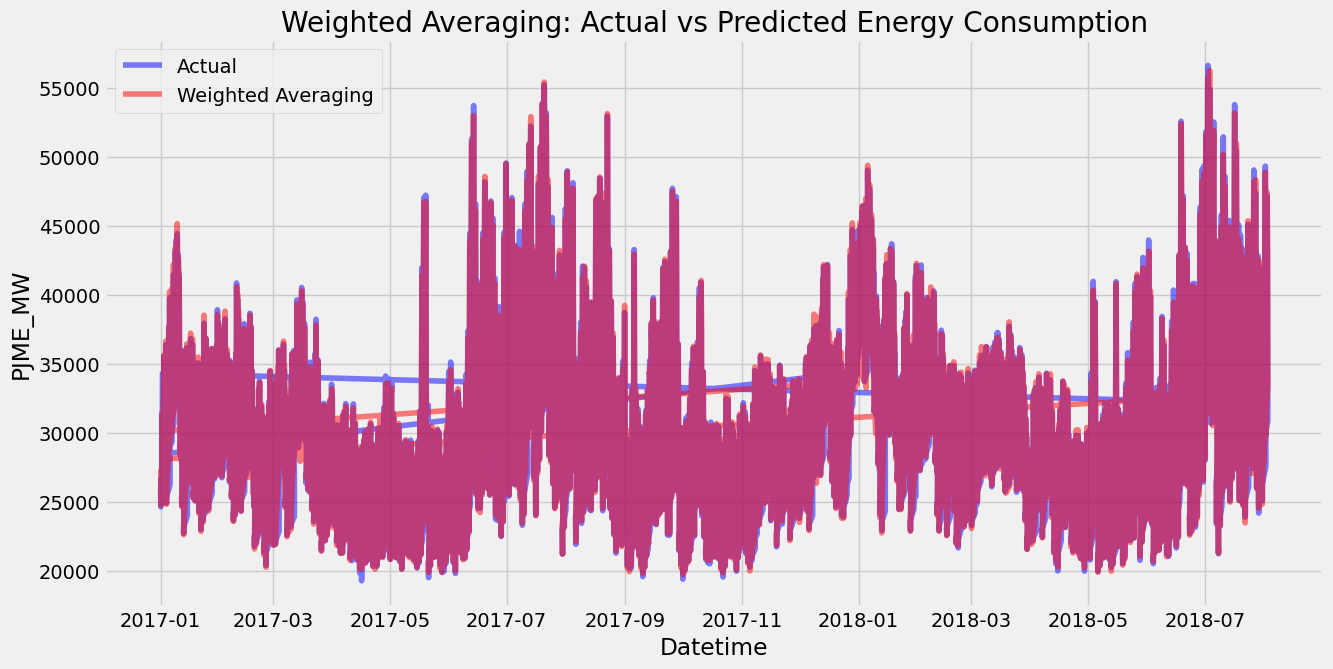

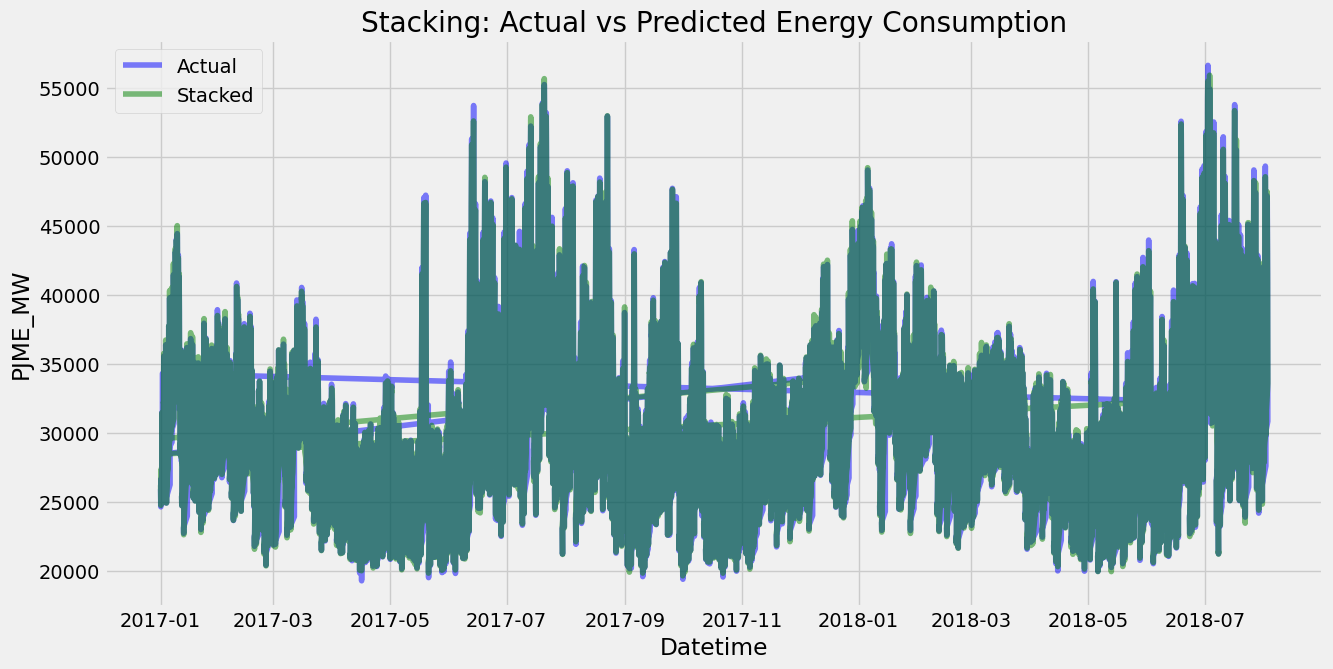

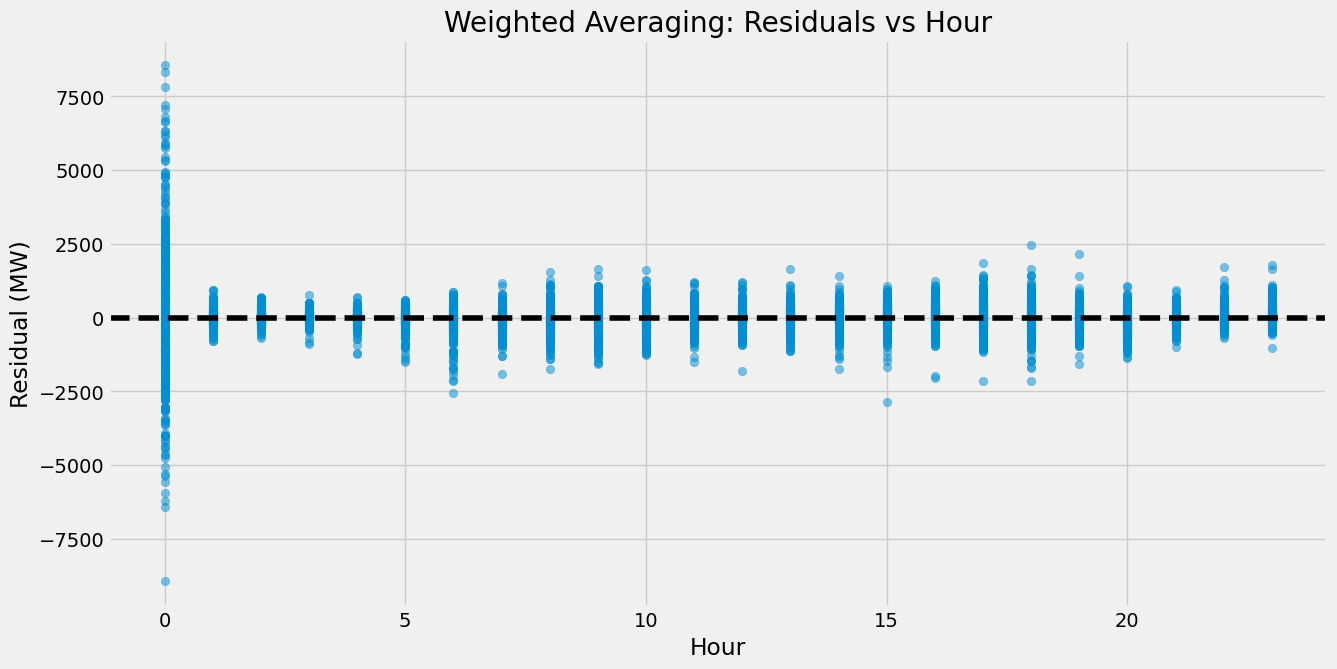

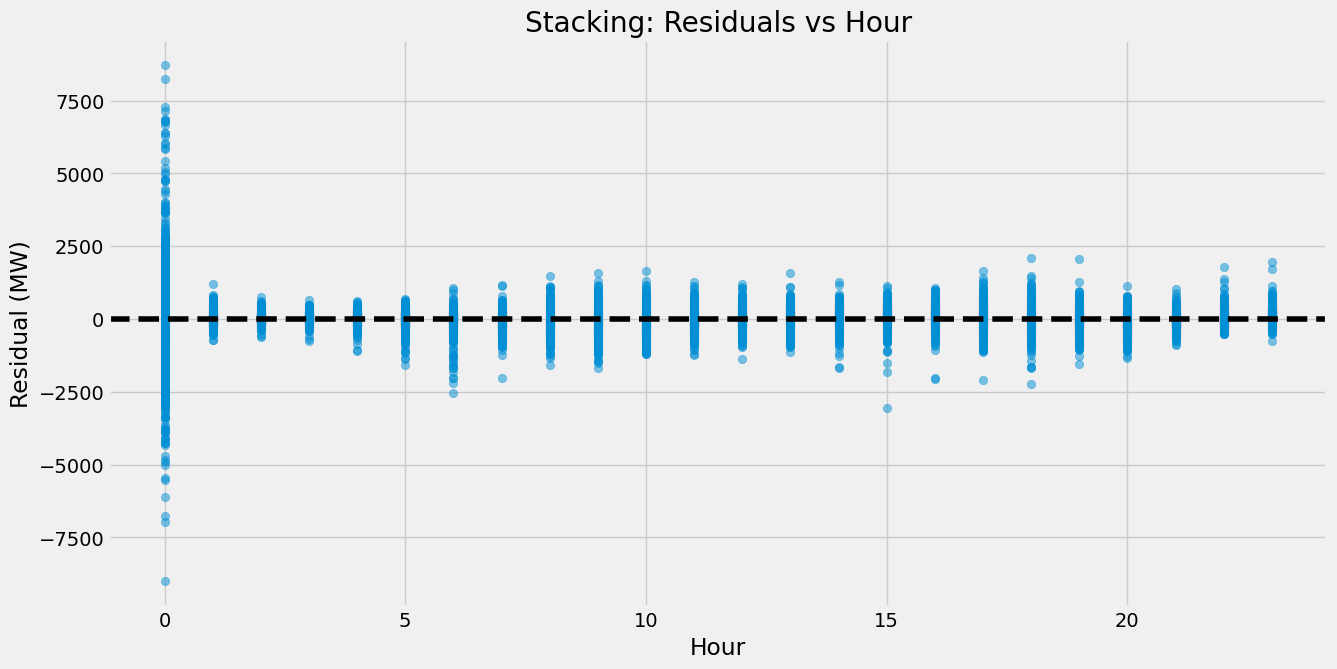

In [ ]:
# Plot Actual vs Predicted for Weighted Averaging
plt.figure(figsize=(14, 7))
plt.plot(test_df.index[:len(y_test)], y_test, label='Actual', color='blue', alpha=0.5)
plt.plot(test_df.index[:len(weighted_pred)], weighted_pred, label='Weighted Averaging', color='red', alpha=0.5)
plt.title('Weighted Averaging: Actual vs Predicted Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

# Plot Actual vs Predicted for Stacking
plt.figure(figsize=(14, 7))
plt.plot(test_df.index[:len(y_test)], y_test, label='Actual', color='blue', alpha=0.5)
plt.plot(test_df.index[:len(stacked_pred)], stacked_pred, label='Stacked', color='green', alpha=0.5)
plt.title('Stacking: Actual vs Predicted Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.legend()
plt.show()

# Residuals for Weighted Averaging
residuals_weighted = y_test - weighted_pred
plt.figure(figsize=(14, 7))
plt.scatter(X_test['hour'], residuals_weighted, alpha=0.5)
plt.title('Weighted Averaging: Residuals vs Hour')
plt.xlabel('Hour')
plt.ylabel('Residual (MW)')
plt.axhline(0, color='black', linestyle='--')
plt.show()

# Residuals for Stacking
residuals_stacked = y_test - stacked_pred
plt.figure(figsize=(14, 7))
plt.scatter(X_test['hour'], residuals_stacked, alpha=0.5)
plt.title('Stacking: Residuals vs Hour')
plt.xlabel('Hour')
plt.ylabel('Residual (MW)')
plt.axhline(0, color='black', linestyle='--')
plt.show()

### **Visual Analysis of Plots**

**Actual vs. Predicted Values**

- **Weighted Averaging:** The "Weighted Averaging: Actual vs Predicted Energy Consumption" plot shows predicted values (red line) closely tracking actual values (blue line) from January 2017 to July 2018, capturing seasonal trends and daily fluctuations. Minor discrepancies occur at peaks (e.g., July 2017, July 2018), where predictions slightly underestimate extremes, and at troughs, where slight overestimations are observed.

- **Stacking:** The "Stacking: Actual vs Predicted Energy Consumption" plot shows predicted values (green line) similarly aligning with actual values (blue line) over the same period. The Stacking model also captures seasonality and trends effectively, with comparable minor deviations at peaks and troughs.

- **Insight:** Both models perform well overall, with predictions closely following actual energy consumption. The Stacking model’s slight metric improvement (e.g., MAE: 323.99 MW vs. 328.02 MW) is not distinctly visible in these plots, indicating marginal differences in overall fit.

**Residuals Analysis**

- **Weighted Averaging:** The "Weighted Averaging: Residuals vs Hour" scatter plot shows Hour 0 residuals ranging from -7500 MW to +7500 MW, with Hours 1–23 residuals clustering within ±2500 MW. The "Residuals over Time" plot shows residuals fluctuating between -10,000 MW and +7500 MW, with larger errors in early 2017.

- **Stacking:** The "Stacking: Residuals vs Hour" box plot confirms large residuals at Hour 0 (-7500 MW to +7500 MW), with a tighter IQR (±500 MW) but numerous extreme outliers. Hours 1–23 show residuals within ±3000 MW, with a median near zero. The "Residuals over Time" plot similarly shows errors up to ±7500 MW, with a cyclical pattern.

- **Insight:** Both models exhibit significantly larger residuals at Hour 0 compared to other hours, highlighting a shared difficulty in predicting energy consumption at this time. The Stacking model’s residuals distribution at Hour 0 is slightly more structured (with a defined IQR), but the presence of extreme outliers indicates persistent challenges.

The Stacking model’s meta-learning approach provides a marginal advantage, but neither model fully addresses the Hour 0 challenge.

---


## Combine XGBoost with a Neural Network Like LSTM

**Why Combine XGBoost with an LSTM?**

- **XGBoost Strengths:**
XGBoost excels at modeling non-linear relationships and interactions in structured, tabular data. It’s likely performing well on our engineered features (e.g., lags, rolling statistics, cyclical encodings like hour_sin and hour_cos). However, it treats each time step independently, which limits its ability to capture temporal dependencies directly—evident in the large residuals at Hour 0 and smoother predictions that miss sharp peaks and troughs.

- **LSTM Strengths:**
LSTMs, a type of recurrent neural network, are designed for sequential data. They can capture long-term dependencies and short-term temporal patterns, such as daily cycles or sudden shifts (e.g., the overnight transition at Hour 0). This makes them ideal for modeling the cyclical seasonality and high-frequency fluctuations in our energy consumption data.

- **Complementary Benefits:**
By combining XGBoost and LSTM, we get the best of both worlds: XGBoost handles complex feature interactions (e.g., weather, holidays), while the LSTM captures temporal dynamics. This hybrid approach should reduce errors at critical points like Hour 0 and improve predictions for peaks (e.g., July 2017, July 2018) and troughs (e.g., April 2017), as seen in the plots.



### **Step 1: Preprocessing for LSTM:**

LSTMs require sequential data. We need to ransform the dataset into sequences of past observations (e.g., the last 24 hours) to capture daily patterns.

In [ ]:
# Define sequence length (e.g., 24 hours for daily patterns)
sequence_length = 24

# Scale data (LSTMs work better with normalized inputs)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Funtion to create sequence
def create_sequences(X, y, sequence_length):
  X_seq, y_seq = [], []
  for i in range(len(X)- sequence_length):
    X_seq.append(X[i:i+sequence_length])  # Sequence of past 24 hours
    y_seq.append(y[i+sequence_length])    # Target: next hour
  return np.array(X_seq), np.array(y_seq)

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, sequence_length)

print(f"X_train_seq shape: {X_train_seq.shape}")  # e.g., (samples, 24, num_features)
print(f"X_test_seq shape: {X_test_seq.shape}")

<ipython-input-31-0e74411734f0>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_seq.append(y[i+sequence_length])    # Target: next hour


X_train_seq shape: (131446, 24, 24)
X_test_seq shape: (13871, 24, 24)


In [ ]:
# Check for NaN in original data
print("NaN in X_train:", np.isnan(X_train).sum().sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("NaN in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("NaN in X_train_seq:", np.isnan(X_train_seq).sum())
print("NaN in y_train_seq:", np.isnan(y_train_seq).sum())

NaN in X_train: 716
NaN in y_train: 0
NaN in X_train_scaled: 716
NaN in X_train_seq: 14976
NaN in y_train_seq: 0


- The nan values originate in X_train, likely from feature engineering steps (e.g., rolling means, lags, or cyclical encodings) that introduce nan when there are gaps or incomplete data for certain windows.

- MinMaxScaler preserves nan values, so X_train_scaled also has 716 nan values.

- When a sequences is created (create_sequences), each sequence is of length 24 (e.g., 24 hours). If any single value in a sequence of 24 time steps is nan, the entire sequence propagates nan. Since each nan in X_train_scaled affects multiple sequences (up to 24 sequences can include a single nan value), the number of nan values in X_train_seq increases significantly to 14,976.

**Impact on LSTM Training:**

The presence of nan in X_train_seq causes the LSTM to produce nan outputs during forward propagation, leading to nan loss values (loss: nan, val_loss: nan). Neural networks propagate nan values through computations, making training impossible.





### Step 2: Train the LSTM Model
We build a simple LSTM model to predict energy consumption based on the sequences.

In [ ]:
# Define LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation="relu", input_shape=(sequence_length, X_train_seq.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

# Compile model
lstm_model.compile(optimizer="adam", loss="mae")

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train model
history = lstm_model.fit(
    X_train_seq,
    y_train_seq,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Predict on test set
lstm_pred = lstm_model.predict(X_test_seq).flatten()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
3287/3287 ━━━━━━━━━━━━━━━━━━━━ 99s 29ms/step - loss: nan - val_loss: nan
Epoch 2/50
3286/3287 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: nan

KeyboardInterrupt: 

In [ ]:
# Step 1: Remove NaN values from X_train and y_train
# Clean data while preserving column names
train_data = pd.concat([X_train, pd.Series(y_train, name='target', index=y_train.index)], axis=1)
train_data_cleaned = train_data.dropna()
X_train_cleaned = train_data_cleaned.drop('target', axis=1)
y_train_cleaned = train_data_cleaned['target']

# Repeat for test data
test_data = pd.concat([X_test, pd.Series(y_test, name='target', index=y_test.index)], axis=1)
test_data_cleaned = test_data.dropna()
X_test_cleaned = test_data_cleaned.drop('target', axis=1)
y_test_cleaned = test_data_cleaned['target']

# Step 2: Scale the cleaned data
# Scale data while preserving column names
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_cleaned.columns, index=X_train_cleaned.index)
X_test_scaled = scaler.transform(X_test_cleaned)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_cleaned.columns, index=X_test_cleaned.index)

# Scale the target variable
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_cleaned.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test_cleaned.values.reshape(-1, 1)).flatten()

# Verify 'hour' column exists
print("Columns in X_train_cleaned:", X_train_cleaned.columns)
print("Columns in X_test_cleaned:", X_test_cleaned.columns)

# Step 3: Define sequence length and create sequences
# Create sequences
sequence_length = 24

def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i+sequence_length])
        y_seq.append(y.iloc[i+sequence_length] if isinstance(y, pd.Series) else y[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)

# Subset features for LSTM (focus on time-series patterns)
lstm_features = ['PJME_MW', 'hour_sin', 'hour_cos']
X_train_lstm_scaled_df = X_train_scaled_df[lstm_features]
X_test_lstm_scaled_df = X_test_scaled_df[lstm_features]
X_train_seq, y_train_seq = create_sequences(X_train_lstm_scaled_df, y_train_cleaned, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_lstm_scaled_df, y_test_cleaned, sequence_length)

# Step 4: Verify if no NaN values remain
print(f"X_train_seq shape: {X_train_seq.shape}")
print(f"X_test_seq shape: {X_test_seq.shape}")
print("NaN in X_train_cleaned:", np.isnan(X_train_cleaned).sum().sum())  # Slightly fewer samples due to NaN removal
print("NaN in y_train_cleaned:", np.isnan(y_train_cleaned).sum())
print("NaN in X_train_scaled:", np.isnan(X_train_scaled).sum())
print("NaN in X_train_seq:", np.isnan(X_train_seq).sum())
print("NaN in y_train_seq:", np.isnan(y_train_seq).sum())
print("NaN in X_test_seq:", np.isnan(X_test_seq).sum())
print("NaN in y_test_seq:", np.isnan(y_test_seq).sum())

Columns in X_train_cleaned: Index(['PJME_MW', 'lag_24', 'lag_48', 'lag_168', 'lag_336', 'hour',
       'day_of_week', 'month', 'quarter', 'year', 'is_weekend', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'is_holiday', 'is_summer', 'is_winter', 'PJME_hour_cos',
       'rolling_mean_24', 'rolling_std_24', 'rolling_mean_48',
       'rolling_std_48', 'is_peak_hour', 'hour_is_holiday', 'hour_is_weekend',
       'is_hour_0', 'is_hour_0_weekend', 'is_hour_0_holiday',
       'is_hour_0_winter', 'rolling_mean_6'],
      dtype='object')
Columns in X_test_cleaned: Index(['PJME_MW', 'lag_24', 'lag_48', 'lag_168', 'lag_336', 'hour',
       'day_of_week', 'month', 'quarter', 'year', 'is_weekend', 'hour_sin',
       'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'is_holiday', 'is_summer', 'is_winter', 'PJME_hour_cos',
       'rolling_mean_24', 'rolling_std_24', 'rolling_mean_48',
       'rolling_std_48', 'is

### Step 3: We'll use a meta-model (Stacking) to combine XGBoost and LSTM predictions
Let’s modify the workflow to skip the initial LSTM training and train the LSTM only during the Stacking phase. This avoids redundancy while ensuring proper OOF predictions for the meta-model. We’ll also ensure that the test set predictions are generated as part of the Stacking process.

We´ll use a XGBoost as a more complex meta-model,
Linear Regression might be too simple to capture the relationship between XGBoost and LSTM predictions, especially given the LSTM’s underperformance.



In [ ]:
# Define LSTM model
lstm_model = Sequential()
# Replace relu with tanh, the default and more stable activation for LSTMs
lstm_model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, X_train_seq.shape[2])))
lstm_model.add(LSTM(64, activation='tanh'))
lstm_model.add(Dropout(0.2))  # Prevent overfitting
lstm_model.add(Dense(1))      # Output: next hour’s energy consumption

# Compile with gradient clipping and lower learning rate
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # Gradient clipping to address exploting gradient
lstm_model.compile(optimizer=optimizer, loss='mae')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# KFold for Stacking
kf = KFold(n_splits=5, shuffle=False)
xgb_oof = np.zeros(len(X_train_cleaned))
lstm_oof = np.zeros(len(X_train_cleaned) - sequence_length)
xgb_test_pred = np.zeros(len(X_test_cleaned) - sequence_length)
lstm_test_pred = np.zeros(len(X_test_cleaned) - sequence_length)

# Generate OOF predictions for both models
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cleaned)):
    print(f"Training fold {fold+1}/{kf.n_splits}")
    X_tr, X_val = X_train_cleaned.iloc[train_idx], X_train_cleaned.iloc[val_idx]
    y_tr, y_val = y_train_cleaned.iloc[train_idx], y_train_cleaned.iloc[val_idx]

    # XGBoost
    best_xgb_model.fit(X_tr, y_tr)
    xgb_oof[val_idx] = best_xgb_model.predict(X_val)
    xgb_test_pred += best_xgb_model.predict(X_test_cleaned)[sequence_length:sequence_length+len(X_test_seq)] / kf.n_splits

    # LSTM
    X_tr_seq, y_tr_seq = create_sequences(X_train_scaled_df[lstm_features].iloc[train_idx], y_train_cleaned.iloc[train_idx], sequence_length)
    X_val_seq, y_val_seq = create_sequences(X_train_scaled_df[lstm_features].iloc[val_idx], y_train_cleaned.iloc[val_idx], sequence_length)
    lstm_model.fit(X_tr_seq, y_tr_seq, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    lstm_pred_val_scaled = lstm_model.predict(X_val_seq).flatten()
    lstm_pred_val = scaler_y.inverse_transform(lstm_pred_val_scaled.reshape(-1, 1)).flatten()
    lstm_oof[val_idx[:len(y_val_seq)]] = lstm_pred_val
    lstm_test_pred += lstm_model.predict(X_test_seq).flatten() / kf.n_splits

# Inverse transform the averaged LSTM test predictions
lstm_test_pred = scaler_y.inverse_transform(lstm_test_pred.reshape(-1, 1)).flatten()

# Train meta-model (use XGBoost instead of Linear Regression)
meta_model = xgb.XGBRegressor(max_depth=3, n_estimators=50)
meta_features = np.column_stack((xgb_oof[sequence_length:sequence_length+len(lstm_oof)], lstm_oof))
meta_model.fit(meta_features, y_train_cleaned.iloc[sequence_length:sequence_length+len(lstm_oof)])

# Final predictions
test_meta_features = np.column_stack((xgb_test_pred, lstm_test_pred))
stacked_pred = meta_model.predict(test_meta_features)

# Evaluate overall performance
y_test_cleaned_aligned = y_test_cleaned.iloc[sequence_length:sequence_length+len(lstm_test_pred)]
mae_stacked = mean_absolute_error(y_test_cleaned_aligned, stacked_pred)
rmse_stacked = np.sqrt(mean_squared_error(y_test_cleaned_aligned, stacked_pred))
mape_stacked = np.mean(np.abs((y_test_cleaned_aligned - stacked_pred) / y_test_cleaned_aligned)) * 100
print(f'Stacked Model Overall MAE: {mae_stacked:.2f} MW')
print(f'Stacked Model Overall RMSE: {rmse_stacked:.2f} MW')
print(f'Stacked Model Overall MAPE: {mape_stacked:.2f} %')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training fold 1/5
Epoch 1/50
2623/2623 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - loss: 32373.1133 - val_loss: 31402.9570
Epoch 2/50
2623/2623 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - loss: 32218.3086 - val_loss: 31235.7012
Epoch 3/50
2623/2623 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 32079.2324 - val_loss: 31067.4434
Epoch 4/50
2623/2623 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 31902.8613 - val_loss: 30897.4492
Epoch 5/50
2623/2623 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 31695.2129 - val_loss: 30727.6035
Epoch 6/50
2623/2623 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 31539.0977 - val_loss: 30557.7617
Epoch 7/50
2623/2623 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 31350.6016 - val_loss: 30387.9160
Epoch 8/50
2623/2623 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 31179.8340 - val_loss: 30218.0527
Epoch 9/50
2623/2623 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 31047.3281 - val_loss: 30048.1992
Epoch 10/50
2623/2623 ━━━━━━━━━━━━━━━━━━━━ 40s 7ms/step - loss: 30855.0000 - val_loss: 29878.3672
Epoch 11/50

In [ ]:
# Evaluate Hour 0 performance
hour_0_mask = X_test_cleaned.iloc[sequence_length:sequence_length+len(lstm_test_pred)]['hour'] == 0
mae_hour_0 = mean_absolute_error(y_test_cleaned_aligned[hour_0_mask], stacked_pred[hour_0_mask])
rmse_hour_0 = np.sqrt(mean_squared_error(y_test_cleaned_aligned[hour_0_mask], stacked_pred[hour_0_mask]))
mape_hour_0 = np.mean(np.abs((y_test_cleaned_aligned[hour_0_mask] - stacked_pred[hour_0_mask]) / y_test_cleaned_aligned[hour_0_mask])) * 100
print(f'Stacked Model Hour 0 MAE: {mae_hour_0:.2f} MW')
print(f'Stacked Model Hour 0 RMSE: {rmse_hour_0:.2f} MW')
print(f'Stacked Model Hour 0 MAPE: {mape_hour_0:.2f} %')

Stacked Model Hour 0 MAE: 2178.34 MW
Stacked Model Hour 0 RMSE: 2851.57 MW
Stacked Model Hour 0 MAPE: 7.95 %


## **Model Performance**
The model was trained on data before 2017 and tested on data from 2017 onward, with the following evaluation metrics:

- **Overall Performance:**
  - Mean Absolute Error (MAE): 534.03 MW
  - Root Mean Squared Error (RMSE): 827.44 MW
  - Mean Absolute Percentage Error (MAPE): 1.74%

- **Hour 0 (Midnight) Performance:**
  - MAE: 2178.34 MW
  - RMSE: 2851.57 MW
  - MAPE: 7.95%

The overall performance is promising, with a low MAPE of 1.74%, indicating good general accuracy. However, the metrics for Hour 0 are significantly worse, with an MAE over four times higher than the overall average and a MAPE approaching 8%. This suggests the model still struggles to predict energy consumption during the midnight transition, likely due to unique patterns or external influences at that time.

---

### **Current Model Setup**

- **Feature Engineering:**

  - Lag features: 24, 48, 168, and 336 hours.
  - Time-based features: cyclical encoding of hour, day of week, and month; binary indicators for weekends, holidays, summer, winter, and peak hours (12 PM–6 PM).
  - Rolling statistics: 6, 24, and 48-hour means and standard deviations.
  - Interaction terms: e.g., PJME_hour_cos, hour_is_holiday, and Hour 0-specific features like is_hour_0, is_hour_0_weekend, is_hour_0_holiday, and is_hour_0_winter.

- **XGBoost:** Tuned via RandomizedSearchCV with parameters like max_depth=3, n_estimators=100, and regularization terms (lambda=10, alpha=20).

- **LSTM:** Two layers (128 and 64 units) with tanh activation, dropout (0.2), and a sequence length of 24 hours, using features PJME_MW, hour_sin, and hour_cos.

< **Stacking:** Out-of-fold predictions from XGBoost and LSTM are combined using an XGBoost meta-model.

- **Data Preprocessing:** MinMaxScaler for features and target, with NaN values dropped after feature creation.

This setup leverages both historical patterns and temporal dynamics, but the Hour 0 performance indicates room for improvement.

---

### **Why Hour 0 Performance Lags**

The midnight transition often involves abrupt changes in energy consumption due to factors like:

- **Overnight behavior shifts:** Reduced human activity or industrial operations.

- **Environmental changes:** Temperature drops affecting heating/cooling demand.

- **Seasonal or weekly patterns:** Variations amplified at midnight.

The current model captures some of these through lag features and Hour 0 indicators, but the high errors suggest it misses critical midnight-specific dynamics.

---

### **Recommendations for Improvement**

To enhance the model, especially at Hour 0, consider the following strategies:

1. **Enhanced Feature Engineering**

  - Additional Lag Features: lag_7*24 (previous week’s same day) to capture short-term and longer-term midnight patterns.

  - Extended Rolling Statistics: Compute rolling means/std over 168 hours (weekly) to capture broader trends leading to midnight.

  - Temperature Interactions: If weather data is available, add temp_hour_0 (temperature at midnight) or temp_diff (change from previous hour) to model environmental impacts.

  - Hour 0 Context: Strengthen midnight-specific features, e.g., rolling_mean_12 (past 12 hours) or is_hour_0_summer for seasonal effects.

2. **LSTM Architecture Adjustments**

  - Increase Capacity: Add a third LSTM layer or increase units (e.g., 256, 128, 64) to capture more complex temporal patterns.

  - Bidirectional LSTM: Use Bidirectional(LSTM(128)) as the first layer to consider both past and future context within the sequence.

  - Attention Mechanism: Add an attention layer post-LSTM to focus on key timesteps (e.g., hours nearing midnight).

  - Sequence Length: Test shorter (12) or longer (48) sequences to optimize dependency capture.

3. **Training Strategy**

  - Custom Loss Function: Weight Hour 0 errors higher, e.g., loss = MAE + w * MAE_hour_0 (where w > 1), to prioritize midnight accuracy.

  - Oversampling Hour 0: Duplicate midnight instances in training data to emphasize these transitions.

  - Fine-Tuning: After initial training, fine-tune on a subset enriched with Hour 0 data.

4. **Ensemble Expansion**

  - Additional Models: Include LightGBM (fast gradient boosting) or Prophet (time-series focused) in the stack to diversify pattern recognition.

  - Meta-Model Tuning: Optimize the XGBoost meta-model with a broader hyperparameter search (e.g., deeper trees or higher n_estimators).

5. **External Data**

  - Weather Data: Integrate hourly temperature, humidity, or wind speed, especially for Hour 0, as overnight weather shifts impact energy use.

  - Event Data: Add indicators for major events (e.g., sports events or outages) that might affect midnight consumption.

6. **Hyperparameter Tuning**

  - XGBoost: Explore higher max_depth (5–7) or lower learning_rate (0.05) for finer adjustments.

  - LSTM: Test lower learning rates (e.g., 0.0001) or adjust batch size (e.g., 64) to stabilize training.

7. **Residual Analysis**

  - Analyze Hour 0 residuals (e.g., y_test_cleaned_aligned[hour_0_mask] - stacked_pred[hour_0_mask]) to identify systematic biases (over/under-prediction) and address them with new features or model tweaks.


### **Implementation Example**

```python
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
# Update LSTM model with attention
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import Bidirectional

# Assuming df is your DataFrame with 'PJME_MW' as the target and a datetime index

# Add hour feature if not present
df['hour'] = df.index.hour
df['target'] = df['PJME_MW']  # Define target explicitly

# Basic sequence creation function for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X.iloc[i:i+seq_length].values)
        y_seq.append(y.iloc[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

# Initialize scaler and KFold
scaler = MinMaxScaler()
scaler_y = MinMaxScaler()  # Separate scaler for target
kf = KFold(n_splits=5, shuffle=True, random_state=42)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
sequence_length = 24  # Example sequence length for LSTM
# Add additional lag features
df['lag_168'] = df['PJME_MW'].shift(7*24)     # Previous week's same hour

# Add extended rolling statistics (weekly)
df['rolling_mean_168'] = df['PJME_MW'].rolling(window=168).mean()
df['rolling_std_168'] = df['PJME_MW'].rolling(window=168).std()

# Add rolling mean for the past 12 hours
df['rolling_mean_12'] = df['PJME_MW'].rolling(window=12).mean()

# Drop NaN values introduced by new features
df.dropna(inplace=True)

# Train-test split
train_df = df.loc[df.index < '2017-01-01']
test_df = df.loc[df.index >= '2017-01-01']

X_train = train_df.drop('target', axis=1)
y_train = train_df['target']
X_test = test_df.drop('target', axis=1)
y_test = test_df['target']

# Clean data while preserving column names
train_data = pd.concat([X_train, pd.Series(y_train, name='target', index=y_train.index)], axis=1)
train_data_cleaned = train_data.dropna()
X_train_cleaned = train_data_cleaned.drop('target', axis=1)
y_train_cleaned = train_data_cleaned['target']

test_data = pd.concat([X_test, pd.Series(y_test, name='target', index=y_test.index)], axis=1)
test_data_cleaned = test_data.dropna()
X_test_cleaned = test_data_cleaned.drop('target', axis=1)
y_test_cleaned = test_data_cleaned['target']

# Scale the data
X_train_scaled = scaler.fit_transform(X_train_cleaned)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_cleaned.columns, index=X_train_cleaned.index)
X_test_scaled = scaler.transform(X_test_cleaned)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_cleaned.columns, index=X_test_cleaned.index)

# Define LSTM features (update as needed based on the dataset)
lstm_features = ['PJME_MW', 'hour', 'lag_1', 'rolling_mean_12']
X_train_lstm_scaled_df = X_train_scaled_df[lstm_features]
X_test_lstm_scaled_df = X_test_scaled_df[lstm_features]

# Add temperature interaction data (if available)
df['temp_hour_0'] = df['temperature'] * df['is_hour_0']

lstm_model = Sequential([
    lstm_model.add(Bidirectional(LSTM(256, activation='tanh', return_sequences=True), input_shape=(sequence_length, X_train_seq.shape[2])))
    lstm_model.add(Bidirectional(LSTM(128, activation='tanh')))
    lstm_model.add(Dropout(0.2))
    Attention(),  # Add attention layer
    LSTM(64, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), loss='mae')

# Identify Hour 0 indices in the training data
hour_0_indices = X_train_cleaned[X_train_cleaned['hour'] == 0].index

# Oversample Hour 0 by duplicating instances
oversample_factor = 2  # Duplicate once
X_train_oversampled = pd.concat([X_train_cleaned, X_train_cleaned.loc[hour_0_indices]])
y_train_oversampled = pd.concat([y_train_cleaned, y_train_cleaned.loc[hour_0_indices]])

# Scale the oversampled data
X_train_oversampled_scaled = scaler.fit_transform(X_train_oversampled)
X_train_oversampled_scaled_df = pd.DataFrame(X_train_oversampled_scaled, columns=X_train_oversampled.columns, index=X_train_oversampled.index)

# Scale the target
y_train_oversampled_scaled = scaler_y.fit_transform(y_train_oversampled.values.reshape(-1, 1)).flatten()

# Create sequences for LSTM using oversampled data
X_train_seq_oversampled, y_train_seq_oversampled = create_sequences(X_train_oversampled_scaled_df[lstm_features], y_train_oversampled_scaled, sequence_length)

# Example training loop with KFold (replace best_xgb_model and lstm_model with the models)
xgb_oof = np.zeros(len(y_train_cleaned))
lstm_oof = np.zeros(len(y_train_cleaned))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_cleaned)):
    print(f"Training fold {fold+1}/{kf.n_splits}")
    
    # XGBoost on oversampled data
    X_tr = X_train_oversampled.iloc[train_idx]
    y_tr = y_train_oversampled.iloc[train_idx]
    X_val = X_train_cleaned.iloc[val_idx]
    y_val = y_train_cleaned.iloc[val_idx]
    best_xgb_model.fit(X_tr, y_tr)  # Replace with XGBoost model
    xgb_oof[val_idx] = best_xgb_model.predict(X_val)
    
    # LSTM on oversampled sequences
    X_tr_seq = X_train_seq_oversampled[train_idx]
    y_tr_seq = y_train_seq_oversampled[train_idx]
    X_val_seq, y_val_seq = create_sequences(X_train_scaled_df[lstm_features].iloc[val_idx], scaler_y.transform(y_train_cleaned.iloc[val_idx].values.reshape(-1, 1)).flatten(), sequence_length)
    lstm_model.fit(X_tr_seq, y_tr_seq, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)  # Replace with LSTM model
    lstm_pred_val_scaled = lstm_model.predict(X_val_seq).flatten()
    lstm_pred_val = scaler_y.inverse_transform(lstm_pred_val_scaled.reshape(-1, 1)).flatten()
    lstm_oof[val_idx[:len(y_val_seq)]] = lstm_pred_val

# Example stacking (simplified)
stacked_pred = (xgb_oof + lstm_oof) / 2  # Adjust based on stacking method

# Assuming stacked_pred is aligned with y_test_cleaned (adjust indices if needed)
y_test_cleaned_aligned = y_test_cleaned.iloc[:len(stacked_pred)]  # Align lengths
hour_0_mask = X_test_cleaned['hour'] == 0
residuals_hour_0 = y_test_cleaned_aligned[hour_0_mask] - stacked_pred[hour_0_mask]

# Plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals_hour_0, bins=50, edgecolor='k')
plt.title('Hour 0 Residuals Distribution')
plt.xlabel('Residual (MW)')
plt.ylabel('Frequency')
plt.show()

# Calculate mean and standard deviation of residuals
mean_residual = residuals_hour_0.mean()
std_residual = residuals_hour_0.std()
print(f"Mean Residual at Hour 0: {mean_residual:.2f} MW")
print(f"Standard Deviation of Residuals at Hour 0: {std_residual:.2f} MW")

# Suggest correction if bias is significant
if abs(mean_residual) > 100:  # Arbitrary threshold
    print("Significant bias detected. Consider adding a correction term.")
```

---

### Expected Impact

Combining these strategies—e.g., enhanced features (lags, weather), a deeper LSTM with attention, and a weighted loss—should reduce Hour 0 MAE significantly (potentially below 1000 MW) while maintaining or improving overall performance. Start with feature engineering and residual analysis, as they’re low-cost and directly target the issue.
